In [7]:
# ExoJulia
## Andrew Lincowski & Spencer Wallace
## Homework 2a: Exoplanet Transits

In [8]:
# Required packages
using LsqFit
using PyPlot

In [9]:
# Random functions
function fastsortrows(B::AbstractMatrix,cols::Array; kws...)
  """
  Solution by: abhishekmalali (gihub)
  See: https://github.com/JuliaLang/julia/issues/9832
  """
       for i = 1:length(cols)
        if i == 1
            p =sortperm(B[:,cols[i]]; kws...);
            B = B[p,:];
        else
            i0_old = 0;
            i1_old = 0;
            i0_new = 0;
            i1_new = 0;
            for j = 1:size(B,1)-1
                if B[j,cols[1:i-1]] == B[j+1,cols[1:i-1]] && i0_old == i0_new
                    i0_new = j;
                elseif B[j,cols[1:i-1]] != B[j+1,cols[1:i-1]] && i0_old != i0_new && i1_new == i1_old
                    i1_new = j;
                elseif i0_old != i0_new && j == size(B,1)-1
                    i1_new = j+1;
                end
                if i0_new != i0_old && i1_new != i1_old
                    p = sortperm(B[i0_new:i1_new,cols[i]]; kws...);
                    B[i0_new:i1_new,:] = B[i0_new:i1_new,:][p,:];
                    i0_old = i0_new;
                    i1_old = i1_new;
                end
            end
            end
    end
    return B
end

fastsortrows (generic function with 1 method)

In [10]:
# Functions

# 1. Compute overlap of two circles as function of their center-center separation (use law of cosines!)



# 2. Compute transit/secondary eclipse of body (no limb darkening)


function pi_crust(delta::Float64,r::Float64)
    # Calculates overlaps of two circles (the sums of their respective pie crusts)
    #r = sqrt(a*a+b*b): separation of circles center-to-center
    #delta = (Rpl/R*)^2
    # r >= 0
    #@printf "r = %f, delta = %f\n" r delta
    #ingress/egress
    if(r >= (1 + sqrt(delta)))
        # outside of transit
        return 0.0
    elseif(r <= (1 - sqrt(delta)))
        # Fully in transit
        return 1.0
    else
        # ingress / egress
        th_st = 2*acos((1+ r*r - delta)/(2*r))
        th_pl = 2*acos((r*r+delta-1)/(2*r*sqrt(delta)))
        alpha = (0.5*th_st - 0.5*sin(th_st) + 0.5*th_pl*delta - 0.5*delta*sin(th_pl))/(pi*delta)
        return alpha
    end
end


# 3. Fit model to mystery_planet2.txt.
#    Calculate planet period P, transit depth K, impact parameter b, and duration of transit T
#    Calculate density of star


function transit(delta,b,t,t0,v,period, base_flux)
    # delta = (Rpl/R*)^2
    # b = impact parameter
    # t = time
    # t0 = center of transit
    # v = velocity
    # period = period
    
    # prevent bad parameters
    if (delta < 0. || delta > 1. || b < 0. || b > 1. || period < 4./v)
        println("Bad parameters")
        return typemin(Float64)
    end
    
    t = mod(t,period)
    a = v*(t-t0)
    r = sqrt(a*a+b*b)

    return base_flux*(1 - pi_crust(delta,r)*delta)
end


function transit_model(x,p)
    
    delta = p[1]
    b = p[2]
    t0 = p[3]
    v = p[4]
    period = p[5]
    base_flux = p[6]
    
    println("Try new set of parameters")
    
    tr_arr = Array(Float64,length(x))
    for i in 1:length(x)
        tr_arr[i] = transit(delta,b,x[i],t0,v, period, base_flux)
    end

    return tr_arr
end


# 4. EXTRA: layer cake modelth

transit_model (generic function with 1 method)

In [11]:
Rst = 1.0
Rpl = 0.1
delta = (Rpl/Rst)^2
b = 0.6
v = 5.0
t0 = 0.5
period = 3.0
base_flux = 22000.

delta = 0.00556306
b = 0.0       
t0 = 0.0      
period = 12.1622   
v = 4./period
base_flux = 22932.4 

t = linspace(0., 10.,10000)
tr_test = Array(Float64,length(t))

for i in 1:length(t)
    tr_test[i] = transit(delta,b,t[i],t0,v, period, base_flux)
end

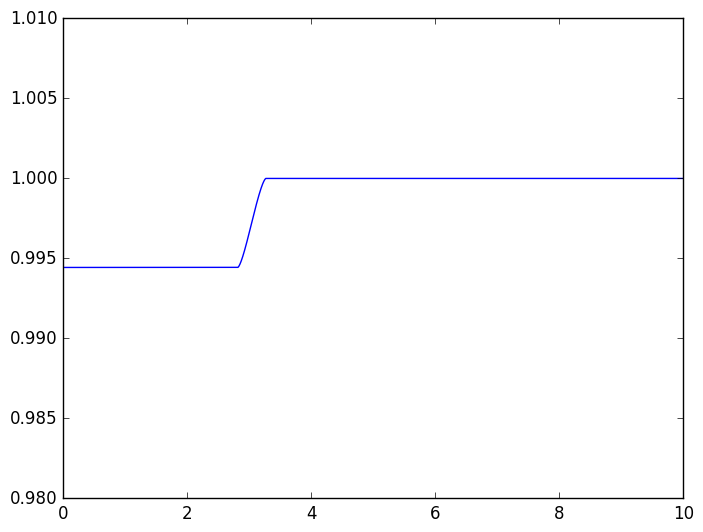

(0.98,1.01)

In [12]:
plot(t,tr_test/base_flux)
ylim([0.98,1.01])
#xlim([0.0,20.0])

In [13]:
# Data import
pldata = readdlm("mystery_planet2.txt")
time_data = pldata[:,1]
flux_data = pldata[:,2]
err_data = pldata[:,3]

10000-element Array{Float64,1}:
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
  ⋮    
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467
 11.467

In [14]:
#Probe useful parameter space for period of planet orbit
period = linspace(10,25,1000)
sum = Array(Float64,length(period))

for (j,P) in enumerate(period)
    sum[j] = 0.0
    
    #Sort by phase, given period
    phase = Array(Real,length(time_data))
    phase = mod(time_data,P)
    phase_data_arr = [phase flux_data] #combine arrays
    phase_sorted = fastsortrows(phase_data_arr, [1]) #sort by phase
    for i in 2:length(time_data)
        sum[j] += (phase_sorted[i,2]-phase_sorted[i-1,2])*(phase_sorted[i,2]-phase_sorted[i-1,2])
    end
end

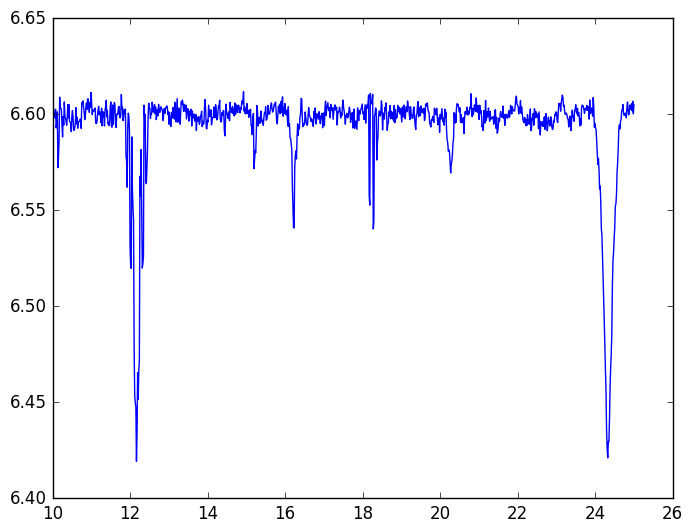

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc0a8225450>

In [15]:
#Plot residuals vs period
plot(period,log10(sum))

In [16]:
#Plot region around minimum of residuals
min_index=indmin(sum)
min_per=period[min_index]

# Period fit (days)
min_per

12.162162162162161

In [17]:
using PyCall
@pyimport scipy as sp
@pyimport scipy.optimize as opt
@pyimport numpy as np

print(sp.__version__)

# Initial values for curve_fit
delta = (maximum(flux_data)-minimum(flux_data))/maximum(flux_data)
b = 0.0
t0 = 0.0
v = 4./min_per
flux = mean(flux_data)

p_bound_low = [0., 0., 0., 4./min_per, -np.inf]
p_bound_hi = [1., 1., np.inf, np.inf, np.inf]

opt.curve_fit(transit_model, time_data, flux_data, p0=[delta,b,t0,v,flux], sigma=err_data)

0.16.1

LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.RuntimeError'>
RuntimeError('Julia exception: MethodError(transit_model,([0.0,0.007,0.014,0.021,0.028,0.035,0.042,0.049,0.056,0.063,0.07,0.077,0.084,0.091,0.098,0.105,0.112,0.119,0.126,0.133,0.14,0.147,0.154,0.161,0.168,0.175,0.182,0.189,0.196,0.203,0.21,0.217,0.224,0.231,0.238,0.245,0.252,0.259,0.266,0.273,0.28,0.287,0.294,0.301,0.308,0.315,0.322,0.329,0.336,0.343,0.35,0.357,0.364,0.371,0.378,0.385,0.392,0.399,0.406,0.413,0.42,0.427,0.434,0.441,0.448,0.455,0.462,0.469,0.476,0.483,0.49,0.497,0.504,0.511,0.518,0.525,0.532,0.539,0.546,0.553,0.56,0.567,0.574,0.581,0.588,0.595,0.602,0.609,0.616,0.623,0.63,0.637,0.644,0.651,0.658,0.665,0.672,0.679,0.686,0.693,0.7,0.707,0.714,0.721,0.728,0.735,0.742,0.749,0.756,0.763,0.77,0.777,0.784,0.791,0.798,0.805,0.812,0.819,0.826,0.833,0.84,0.847,0.854,0.861,0.868,0.875,0.882,0.889,0.896,0.903,0.91,0.917,0.924,0.931,0.938,0.945,0.952,0.959,0.966,0.973,0.98,0.987,0.994,1.001,1.008,1.015,1.022,1.029,1.036,1.043,1.05,1.057,1.064,1.071,1.078,1.085,1.092,1.099,1.106,1.113,1.12,1.127,1.134,1.141,1.148,1.155,1.162,1.169,1.176,1.183,1.19,1.197,1.204,1.211,1.218,1.225,1.232,1.239,1.246,1.253,1.26,1.267,1.274,1.281,1.288,1.295,1.302,1.309,1.316,1.323,1.33,1.337,1.344,1.351,1.358,1.365,1.372,1.379,1.386,1.393,1.4,1.407,1.414,1.421,1.428,1.435,1.442,1.449,1.456,1.463,1.47,1.477,1.484,1.491,1.498,1.505,1.512,1.519,1.526,1.533,1.54,1.547,1.554,1.561,1.568,1.575,1.582,1.589,1.596,1.603,1.61,1.617,1.624,1.631,1.638,1.645,1.652,1.659,1.666,1.673,1.68,1.687,1.694,1.701,1.708,1.715,1.722,1.729,1.736,1.743,1.75,1.757,1.764,1.771,1.778,1.785,1.792,1.799,1.806,1.813,1.82,1.827,1.834,1.841,1.848,1.855,1.862,1.869,1.876,1.883,1.89,1.897,1.904,1.911,1.918,1.925,1.932,1.939,1.946,1.953,1.96,1.967,1.974,1.981,1.988,1.995,2.002,2.009,2.016,2.023,2.03,2.037,2.044,2.051,2.058,2.065,2.072,2.079,2.086,2.093,2.1,2.107,2.114,2.121,2.128,2.135,2.142,2.149,2.156,2.163,2.17,2.177,2.184,2.191,2.198,2.205,2.212,2.219,2.226,2.233,2.24,2.247,2.254,2.261,2.268,2.275,2.282,2.289,2.296,2.303,2.31,2.317,2.324,2.331,2.338,2.345,2.352,2.359,2.366,2.373,2.38,2.387,2.394,2.401,2.408,2.415,2.422,2.429,2.436,2.443,2.45,2.457,2.464,2.471,2.478,2.485,2.492,2.499,2.506,2.513,2.52,2.527,2.534,2.541,2.548,2.555,2.562,2.569,2.576,2.583,2.59,2.597,2.604,2.611,2.618,2.625,2.632,2.639,2.646,2.653,2.66,2.667,2.674,2.681,2.688,2.695,2.702,2.709,2.716,2.723,2.73,2.737,2.744,2.751,2.758,2.765,2.772,2.779,2.786,2.793,2.8,2.807,2.814,2.821,2.828,2.835,2.842,2.849,2.856,2.863,2.87,2.877,2.884,2.891,2.898,2.905,2.912,2.919,2.926,2.933,2.94,2.947,2.954,2.961,2.968,2.975,2.982,2.989,2.996,3.003,3.01,3.017,3.024,3.031,3.038,3.045,3.052,3.059,3.066,3.073,3.08,3.087,3.094,3.101,3.108,3.115,3.122,3.129,3.136,3.143,3.15,3.157,3.164,3.171,3.178,3.185,3.192,3.199,3.206,3.213,3.22,3.227,3.234,3.241,3.248,3.255,3.262,3.269,3.276,3.283,3.29,3.297,3.304,3.311,3.318,3.325,3.332,3.339,3.346,3.353,3.36,3.367,3.374,3.381,3.388,3.395,3.402,3.409,3.416,3.423,3.43,3.437,3.444,3.451,3.458,3.465,3.472,3.479,3.486,3.493,3.5,3.507,3.514,3.521,3.528,3.535,3.542,3.549,3.556,3.563,3.57,3.577,3.584,3.591,3.598,3.605,3.612,3.619,3.626,3.633,3.64,3.647,3.654,3.661,3.668,3.675,3.682,3.689,3.696,3.703,3.71,3.717,3.724,3.731,3.738,3.745,3.752,3.759,3.766,3.773,3.78,3.787,3.794,3.801,3.808,3.815,3.822,3.829,3.836,3.843,3.85,3.857,3.864,3.871,3.878,3.885,3.892,3.899,3.906,3.913,3.92,3.927,3.934,3.941,3.948,3.955,3.962,3.969,3.976,3.983,3.99,3.997,4.004,4.011,4.018,4.025,4.032,4.039,4.046,4.053,4.06,4.067,4.074,4.081,4.088,4.095,4.102,4.109,4.116,4.123,4.13,4.137,4.144,4.151,4.158,4.165,4.172,4.179,4.186,4.193,4.2,4.207,4.214,4.221,4.228,4.235,4.242,4.249,4.256,4.263,4.27,4.277,4.284,4.291,4.298,4.305,4.312,4.319,4.326,4.333,4.34,4.347,4.354,4.361,4.368,4.375,4.382,4.389,4.396,4.403,4.41,4.417,4.424,4.431,4.438,4.445,4.452,4.459,4.466,4.473,4.48,4.487,4.494,4.501,4.508,4.515,4.522,4.529,4.536,4.543,4.55,4.557,4.564,4.571,4.578,4.585,4.592,4.599,4.606,4.613,4.62,4.627,4.634,4.641,4.648,4.655,4.662,4.669,4.676,4.683,4.69,4.697,4.704,4.711,4.718,4.725,4.732,4.739,4.746,4.753,4.76,4.767,4.774,4.781,4.788,4.795,4.802,4.809,4.816,4.823,4.83,4.837,4.844,4.851,4.858,4.865,4.872,4.879,4.886,4.893,4.9,4.907,4.914,4.921,4.928,4.935,4.942,4.949,4.956,4.963,4.97,4.977,4.984,4.991,4.998,5.005,5.012,5.019,5.026,5.033,5.04,5.047,5.054,5.061,5.068,5.075,5.082,5.089,5.096,5.103,5.11,5.117,5.124,5.131,5.138,5.145,5.152,5.159,5.166,5.173,5.18,5.187,5.194,5.201,5.208,5.215,5.222,5.229,5.236,5.243,5.25,5.257,5.264,5.271,5.278,5.285,5.292,5.299,5.306,5.313,5.32,5.327,5.334,5.341,5.348,5.355,5.362,5.369,5.376,5.383,5.39,5.397,5.404,5.411,5.418,5.425,5.432,5.439,5.446,5.453,5.46,5.467,5.474,5.481,5.488,5.495,5.502,5.509,5.516,5.523,5.53,5.537,5.544,5.551,5.558,5.565,5.572,5.579,5.586,5.593,5.6,5.607,5.614,5.621,5.628,5.635,5.642,5.649,5.656,5.663,5.67,5.677,5.684,5.691,5.698,5.705,5.712,5.719,5.726,5.733,5.74,5.747,5.754,5.761,5.768,5.775,5.782,5.789,5.796,5.803,5.81,5.817,5.824,5.831,5.838,5.845,5.852,5.859,5.866,5.873,5.88,5.887,5.894,5.901,5.908,5.915,5.922,5.929,5.936,5.943,5.95,5.957,5.964,5.971,5.978,5.985,5.992,5.999,6.006,6.013,6.02,6.027,6.034,6.041,6.048,6.055,6.062,6.069,6.076,6.083,6.09,6.097,6.104,6.111,6.118,6.125,6.132,6.139,6.146,6.153,6.16,6.167,6.174,6.181,6.188,6.195,6.202,6.209,6.216,6.223,6.23,6.237,6.244,6.251,6.258,6.265,6.272,6.279,6.286,6.293,6.3,6.307,6.314,6.321,6.328,6.335,6.342,6.349,6.356,6.363,6.37,6.377,6.384,6.391,6.398,6.405,6.412,6.419,6.426,6.433,6.44,6.447,6.454,6.461,6.468,6.475,6.482,6.489,6.496,6.503,6.51,6.517,6.524,6.531,6.538,6.545,6.552,6.559,6.566,6.573,6.58,6.587,6.594,6.601,6.608,6.615,6.622,6.629,6.636,6.643,6.65,6.657,6.664,6.671,6.678,6.685,6.692,6.699,6.706,6.713,6.72,6.727,6.734,6.741,6.748,6.755,6.762,6.769,6.776,6.783,6.79,6.797,6.804,6.811,6.818,6.825,6.832,6.839,6.846,6.853,6.86,6.867,6.874,6.881,6.888,6.895,6.902,6.909,6.916,6.923,6.93,6.937,6.944,6.951,6.958,6.965,6.972,6.979,6.986,6.993,7.0,7.007,7.014,7.021,7.028,7.035,7.042,7.049,7.056,7.063,7.07,7.077,7.084,7.091,7.098,7.105,7.112,7.119,7.126,7.133,7.14,7.147,7.154,7.161,7.168,7.175,7.182,7.189,7.196,7.203,7.21,7.217,7.224,7.231,7.238,7.245,7.252,7.259,7.266,7.273,7.28,7.287,7.294,7.301,7.308,7.315,7.322,7.329,7.336,7.343,7.35,7.357,7.364,7.371,7.378,7.385,7.392,7.399,7.406,7.413,7.42,7.427,7.434,7.441,7.448,7.455,7.462,7.469,7.476,7.483,7.49,7.497,7.504,7.511,7.518,7.525,7.532,7.539,7.546,7.553,7.56,7.567,7.574,7.581,7.588,7.595,7.602,7.609,7.616,7.623,7.63,7.637,7.644,7.651,7.658,7.665,7.672,7.679,7.686,7.693,7.7,7.707,7.714,7.721,7.728,7.735,7.742,7.749,7.756,7.763,7.77,7.777,7.784,7.791,7.798,7.805,7.812,7.819,7.826,7.833,7.84,7.847,7.854,7.861,7.868,7.875,7.882,7.889,7.896,7.903,7.91,7.917,7.924,7.931,7.938,7.945,7.952,7.959,7.966,7.973,7.98,7.987,7.994,8.000999,8.008,8.015,8.022,8.028999,8.036,8.043,8.05,8.057,8.064,8.071,8.078,8.085,8.092,8.099,8.106,8.113,8.12,8.127,8.134,8.141,8.148001,8.155,8.162,8.169,8.176001,8.183,8.19,8.197001,8.204,8.210999,8.217999,8.225,8.232,8.239,8.246,8.253,8.26,8.267,8.274,8.281,8.288,8.295,8.302,8.309,8.316,8.323,8.33,8.337,8.344,8.351,8.358,8.365,8.372,8.379,8.386,8.393001,8.4,8.407,8.414001,8.421,8.427999,8.434999,8.442,8.449,8.456,8.463,8.47,8.477,8.484,8.491,8.498,8.505,8.512,8.519,8.526,8.533,8.54,8.547,8.554,8.561,8.568,8.575,8.582,8.589,8.596,8.603,8.610001,8.617,8.624,8.631001,8.638,8.645,8.651999,8.659,8.666,8.672999,8.68,8.687,8.694,8.701,8.708,8.715,8.722,8.729,8.736,8.743,8.75,8.757,8.764,8.771,8.778001,8.785,8.792,8.799,8.806,8.813,8.82,8.827001,8.834001,8.841001,8.848,8.855,8.862,8.868999,8.876,8.883,8.89,8.897,8.904,8.910999,8.917999,8.925,8.932,8.939,8.946,8.953,8.96,8.966999,8.974,8.981,8.988,8.995,9.002,9.009,9.016001,9.023001,9.03,9.037,9.044,9.051,9.058,9.065001,9.072001,9.079,9.086,9.092999,9.099999,9.106999,9.114,9.121,9.128,9.135,9.142,9.149,9.155999,9.163,9.17,9.177,9.184,9.191,9.198,9.205,9.212001,9.219,9.226,9.233,9.24,9.247,9.254,9.261001,9.268001,9.275,9.282,9.289,9.296,9.302999,9.31,9.317,9.324,9.331,9.337999,9.344999,9.351999,9.359,9.366,9.373,9.38,9.387,9.394,9.400999,9.408,9.415,9.422,9.429,9.436,9.443,9.450001,9.457001,9.464,9.471,9.478,9.485,9.492,9.499001,9.506001,9.513,9.52,9.526999,9.533999,9.540999,9.548,9.555,9.562,9.569,9.576,9.582999,9.589999,9.597,9.604,9.611,9.618,9.625,9.632,9.639001,9.646,9.653,9.66,9.667,9.674,9.681,9.688001,9.695001,9.702001,9.709,9.716,9.723,9.73,9.737,9.744,9.751,9.758,9.765,9.771999,9.778999,9.786,9.793,9.8,9.807,9.814,9.821,9.828,9.835,9.842,9.849,9.856,9.863,9.87,9.877,9.884001,9.891,9.898,9.905,9.912,9.919,9.926,9.933001,9.940001,9.947001,9.954,9.960999,9.967999,9.974999,9.982,9.989,9.996,10.003,10.01,10.016999,10.023999,10.031,10.038,10.045,10.052,10.059,10.066,10.073001,10.08,10.087,10.094,10.101,10.108,10.115,10.122001,10.129001,10.136001,10.143,10.15,10.157,10.164,10.171,10.178,10.185,10.192,10.198999,10.205999,10.212999,10.22,10.227,10.234,10.241,10.248,10.255,10.261999,10.269,10.276,10.283,10.29,10.297,10.304,10.311001,10.318001,10.325,10.332,10.339,10.346,10.353,10.360001,10.367001,10.374001,10.381001,10.388,10.395,10.401999,10.409,10.416,10.423,10.43,10.437,10.444,10.450999,10.458,10.465,10.472,10.479,10.486,10.493,10.5,10.507,10.514,10.521,10.528,10.535,10.542,10.549,10.556001,10.563001,10.57,10.577,10.584,10.591,10.598,10.605,10.612,10.619,10.626,10.632999,10.639999,10.646999,10.654,10.661,10.668,10.675,10.682,10.689,10.695999,10.703,10.71,10.717,10.724,10.731,10.738,10.745001,10.752001,10.759,10.766,10.773,10.78,10.787,10.794001,10.801001,10.808001,10.815,10.822,10.829,10.835999,10.843,10.85,10.857,10.864,10.871,10.877999,10.884999,10.892,10.899,10.906,10.913,10.92,10.927,10.934,10.941,10.948,10.955,10.962,10.969,10.976,10.983,10.990001,10.997001,11.004,11.011,11.018,11.025,11.032,11.039001,11.046,11.053,11.06,11.066999,11.073999,11.080999,11.088,11.095,11.102,11.109,11.116,11.122999,11.129999,11.137,11.144,11.151,11.158,11.165,11.172,11.179001,11.186,11.193,11.2,11.207,11.214,11.221,11.228001,11.235001,11.242001,11.249,11.256,11.263,11.27,11.277,11.284,11.291,11.298,11.305,11.311999,11.318999,11.326,11.333,11.34,11.347,11.354,11.361,11.368,11.375,11.382,11.389,11.396,11.403,11.41,11.417,11.424001,11.431,11.438,11.445,11.452,11.459,11.466,11.473001,11.48,11.487,11.493999,11.500999,11.507999,11.514999,11.522,11.529,11.536,11.543,11.55,11.556999,11.563999,11.571,11.578,11.585,11.592,11.599,11.606,11.613001,11.62,11.627,11.634,11.641,11.648,11.655,11.662001,11.669001,11.676001,11.683,11.69,11.697,11.704,11.711,11.718,11.725,11.732,11.738999,11.745999,11.752999,11.76,11.767,11.774,11.781,11.788,11.795,11.801999,11.809,11.816,11.823,11.83,11.837,11.844,11.851001,11.858001,11.865,11.872,11.879,11.886,11.893,11.900001,11.907001,11.914001,11.921,11.927999,11.934999,11.941999,11.949,11.956,11.963,11.97,11.977,11.984,11.990999,11.998,12.005,12.012,12.019,12.026,12.033,12.04,12.047,12.054,12.061,12.068,12.075,12.082,12.089,12.096001,12.103001,12.11,12.117,12.124,12.131,12.138,12.145,12.152,12.159,12.166,12.172999,12.179999,12.186999,12.194,12.201,12.208,12.215,12.222,12.229,12.235999,12.243,12.25,12.257,12.264,12.271,12.278,12.285001,12.292001,12.299,12.306,12.313,12.32,12.327,12.334001,12.341001,12.348001,12.355,12.362,12.368999,12.375999,12.383,12.39,12.397,12.404,12.411,12.417999,12.424999,12.432,12.439,12.446,12.453,12.46,12.467,12.474001,12.481,12.488,12.495,12.502,12.509,12.516,12.523001,12.530001,12.537001,12.544,12.551,12.558,12.565,12.572001,12.579,12.586,12.593,12.6,12.606999,12.613999,12.621,12.628,12.635,12.642,12.649,12.656,12.662999,12.67,12.677,12.684,12.691,12.698,12.705,12.712,12.719001,12.726,12.733,12.74,12.747,12.754,12.761,12.768001,12.775001,12.782001,12.789,12.796,12.802999,12.809999,12.817,12.824,12.831,12.838,12.845,12.851999,12.858999,12.866,12.873,12.88,12.887,12.894,12.901,12.908001,12.915,12.922,12.929,12.936,12.943,12.95,12.957001,12.964001,12.971,12.978,12.985,12.992,12.999,13.006001,13.013,13.02,13.027,13.033999,13.040999,13.047999,13.055,13.062,13.069,13.076,13.083,13.09,13.096999,13.104,13.111,13.118,13.125,13.132,13.139,13.146,13.153001,13.16,13.167,13.174,13.181,13.188,13.195,13.202001,13.209001,13.216001,13.223,13.23,13.237,13.243999,13.251,13.258,13.265,13.272,13.279,13.285999,13.292999,13.3,13.307,13.314,13.321,13.328,13.335,13.341999,13.349,13.356,13.363,13.37,13.377,13.384,13.391001,13.398001,13.405,13.412,13.419,13.426,13.433,13.440001,13.447001,13.454,13.461,13.467999,13.474999,13.481999,13.489,13.496,13.503,13.51,13.517,13.524,13.530999,13.538,13.545,13.552,13.559,13.566,13.573,13.58,13.587001,13.594,13.601,13.608,13.615,13.622,13.629,13.636001,13.643001,13.65,13.657,13.664,13.671,13.677999,13.685,13.692,13.699,13.706,13.712999,13.719999,13.726999,13.734,13.741,13.748,13.755,13.762,13.769,13.775999,13.783,13.79,13.797,13.804,13.811,13.818,13.825001,13.832001,13.839,13.846,13.853,13.86,13.867,13.874001,13.881001,13.888,13.895,13.901999,13.908999,13.915999,13.923,13.93,13.937,13.944,13.951,13.957999,13.964999,13.972,13.979,13.986,13.993,14.0,14.007,14.014001,14.021,14.028,14.035,14.042,14.049,14.056,14.063001,14.070001,14.077001,14.084,14.091,14.098,14.105,14.112,14.119,14.126,14.133,14.14,14.146999,14.153999,14.161,14.168,14.175,14.182,14.189,14.196,14.203,14.21,14.217,14.224,14.231,14.238,14.245,14.252,14.259001,14.266,14.273,14.28,14.287,14.294,14.301,14.308001,14.315001,14.322001,14.329,14.335999,14.342999,14.349999,14.357,14.364,14.371,14.378,14.385,14.391999,14.398999,14.406,14.413,14.42,14.427,14.434,14.441,14.448001,14.455,14.462,14.469,14.476,14.483,14.49,14.497001,14.504001,14.511001,14.518,14.525,14.532,14.539,14.546,14.553,14.56,14.567,14.573999,14.580999,14.587999,14.595,14.602,14.609,14.616,14.623,14.63,14.636999,14.644,14.651,14.658,14.665,14.672,14.679,14.686001,14.693001,14.7,14.707,14.714,14.721,14.728,14.735001,14.742001,14.749001,14.756001,14.763,14.77,14.776999,14.784,14.791,14.798,14.805,14.812,14.819,14.825999,14.833,14.84,14.847,14.854,14.861,14.868,14.875,14.882,14.889,14.896,14.903,14.91,14.917,14.924,14.931001,14.938001,14.945,14.952,14.959,14.966,14.973,14.98,14.987,14.994,15.001,15.007999,15.014999,15.021999,15.029,15.036,15.043,15.05,15.057,15.064,15.070999,15.078,15.085,15.092,15.099,15.106,15.113,15.120001,15.127001,15.134,15.141,15.148,15.155,15.162,15.169001,15.176001,15.183001,15.19,15.197,15.204,15.210999,15.218,15.225,15.232,15.239,15.246,15.252999,15.259999,15.267,15.274,15.281,15.288,15.295,15.302,15.309,15.316,15.323,15.33,15.337,15.344,15.351,15.358,15.365001,15.372001,15.379,15.386,15.393,15.4,15.407,15.414001,15.421,15.428,15.435,15.441999,15.448999,15.455999,15.463,15.47,15.477,15.484,15.491,15.497999,15.504999,15.512,15.519,15.526,15.533,15.54,15.547,15.554001,15.561,15.568,15.575,15.582,15.589,15.596,15.603001,15.610001,15.617001,15.624,15.631,15.638,15.645,15.652,15.659,15.666,15.673,15.68,15.686999,15.693999,15.701,15.708,15.715,15.722,15.729,15.736,15.743,15.75,15.757,15.764,15.771,15.778,15.785,15.792,15.799001,15.806,15.813,15.82,15.827,15.834,15.841,15.848001,15.855,15.862,15.868999,15.875999,15.882999,15.889999,15.897,15.904,15.911,15.918,15.925,15.931999,15.938999,15.946,15.953,15.96,15.967,15.974,15.981,15.988001,15.995,16.001999,16.008999,16.016001,16.023001,16.030001,16.037001,16.044001,16.051001,16.057999,16.065001,16.072001,16.079,16.086,16.093,16.1,16.107,16.114,16.121,16.128,16.135,16.142,16.149,16.156,16.163,16.17,16.177,16.184,16.191,16.198,16.205,16.212,16.219,16.226,16.233,16.24,16.247,16.254,16.261,16.268,16.275,16.282,16.289,16.296001,16.302999,16.309999,16.316999,16.323999,16.330999,16.337999,16.345001,16.352001,16.359001,16.365999,16.372999,16.379999,16.386999,16.394001,16.401001,16.408001,16.415001,16.421999,16.428999,16.435999,16.443001,16.450001,16.457001,16.464001,16.471001,16.478001,16.484999,16.492001,16.499001,16.506001,16.513,16.52,16.527,16.534,16.541,16.548,16.555,16.562,16.569,16.576,16.583,16.59,16.597,16.604,16.611,16.618,16.625,16.632,16.639,16.646,16.653,16.66,16.667,16.674,16.681,16.688,16.695,16.702,16.709,16.716,16.723,16.73,16.737,16.743999,16.750999,16.757999,16.764999,16.771999,16.779001,16.786001,16.792999,16.799999,16.806999,16.813999,16.820999,16.828001,16.835001,16.842001,16.849001,16.855999,16.862999,16.869999,16.877001,16.884001,16.891001,16.898001,16.905001,16.912001,16.918999,16.926001,16.933001,16.940001,16.947001,16.954,16.961,16.968,16.975,16.982,16.989,16.996,17.003,17.01,17.017,17.024,17.031,17.038,17.045,17.052,17.059,17.066,17.073,17.08,17.087,17.094,17.101,17.108,17.115,17.122,17.129,17.136,17.143,17.15,17.157,17.164,17.171,17.177999,17.184999,17.191999,17.198999,17.205999,17.213001,17.220001,17.226999,17.233999,17.240999,17.247999,17.254999,17.262001,17.269001,17.276001,17.283001,17.289999,17.296999,17.303999,17.311001,17.318001,17.325001,17.332001,17.339001,17.345999,17.352999,17.360001,17.367001,17.374001,17.381001,17.388,17.395,17.402,17.409,17.416,17.423,17.43,17.437,17.444,17.451,17.458,17.465,17.472,17.479,17.486,17.493,17.5,17.507,17.514,17.521,17.528,17.535,17.542,17.549,17.556002,17.563,17.57,17.577,17.584,17.591,17.598,17.605001,17.612,17.619001,17.625999,17.632999,17.639999,17.646999,17.654001,17.660999,17.668001,17.674999,17.682001,17.688999,17.695999,17.703001,17.709999,17.717001,17.723999,17.731001,17.737999,17.745001,17.752001,17.758999,17.766001,17.772999,17.780001,17.786999,17.794001,17.801001,17.808001,17.815001,17.821999,17.829,17.835999,17.843,17.85,17.857,17.864,17.870998,17.878,17.884998,17.892,17.899,17.906,17.913,17.92,17.927,17.933998,17.941,17.948,17.955,17.962,17.969,17.976,17.983002,17.99,17.997,18.004,18.011,18.018,18.025,18.032001,18.039,18.046001,18.052999,18.059999,18.066999,18.073999,18.081001,18.087999,18.095001,18.101999,18.109001,18.115999,18.122999,18.130001,18.136999,18.144001,18.150999,18.158001,18.164999,18.172001,18.179001,18.185999,18.193001,18.199999,18.207001,18.213999,18.221001,18.228001,18.235001,18.242001,18.248999,18.256001,18.262999,18.27,18.277,18.284,18.291,18.298,18.305,18.311998,18.319,18.326,18.333,18.34,18.347,18.354,18.361,18.368,18.375,18.382,18.389,18.396,18.403,18.41,18.417,18.424002,18.431,18.438,18.445,18.452,18.459,18.466,18.473001,18.48,18.487,18.493999,18.500999,18.507999,18.514999,18.522001,18.528999,18.536001,18.542999,18.549999,18.556999,18.563999,18.571001,18.577999,18.585001,18.591999,18.599001,18.605999,18.612999,18.620001,18.626999,18.634001,18.640999,18.648001,18.654999,18.662001,18.669001,18.675999,18.683001,18.689999,18.697001,18.703999,18.711,18.718,18.725,18.732,18.738998,18.746,18.752998,18.76,18.767,18.774,18.781,18.788,18.795,18.801998,18.809,18.816,18.823,18.83,18.837,18.844,18.851002,18.858,18.865,18.872,18.879,18.886,18.893,18.900002,18.907,18.914001,18.921,18.927999,18.934999,18.941999,18.949001,18.955999,18.963001,18.969999,18.977001,18.983999,18.990999,18.998001,19.004999,19.012001,19.018999,19.026001,19.032999,19.040001,19.047001,19.053999,19.061001,19.067999,19.075001,19.081999,19.089001,19.096001,19.102999,19.110001,19.116999,19.124001,19.130999,19.138,19.145,19.152,19.159,19.165998,19.173,19.179998,19.187,19.194,19.201,19.208,19.215,19.222,19.228998,19.236,19.243,19.25,19.257,19.264,19.271,19.278002,19.285,19.292,19.299,19.306,19.313,19.32,19.327002,19.334,19.341002,19.348,19.355,19.362,19.368999,19.376001,19.382999,19.390001,19.396999,19.404001,19.410999,19.417999,19.425001,19.431999,19.439001,19.445999,19.453001,19.459999,19.467001,19.474001,19.480999,19.488001,19.494999,19.502001,19.508999,19.516001,19.523001,19.530001,19.537001,19.543999,19.551001,19.557999,19.565001,19.572001,19.579,19.586,19.593,19.6,19.606998,19.614,19.621,19.628,19.635,19.642,19.649,19.656,19.663,19.67,19.677,19.684,19.691,19.698,19.705,19.712,19.719,19.726,19.733,19.74,19.747,19.754,19.761,19.768002,19.775,19.782,19.789,19.796,19.802999,19.809999,19.817001,19.823999,19.831001,19.837999,19.844999,19.851999,19.858999,19.866001,19.872999,19.880001,19.886999,19.894001,19.900999,19.907999,19.915001,19.921999,19.929001,19.935999,19.943001,19.949999,19.957001,19.964001,19.970999,19.978001,19.984999,19.992001,19.998999,20.006001,20.013,20.02,20.027,20.033998,20.041,20.047998,20.055,20.062,20.069,20.076,20.083,20.09,20.096998,20.104,20.111,20.118,20.125,20.132,20.139,20.146002,20.153,20.16,20.167,20.174,20.181,20.188,20.195002,20.202,20.209002,20.216,20.223,20.23,20.237,20.244001,20.250999,20.258001,20.264999,20.272001,20.278999,20.285999,20.293001,20.299999,20.307001,20.313999,20.321001,20.327999,20.334999,20.342001,20.348999,20.356001,20.362999,20.370001,20.376999,20.384001,20.391001,20.397999,20.405001,20.411999,20.419001,20.425999,20.433001,20.440001,20.447001,20.454,20.460999,20.468,20.474998,20.482,20.489,20.496,20.503,20.51,20.517,20.523998,20.531,20.538,20.545,20.552,20.559,20.566,20.573002,20.58,20.587,20.594,20.601,20.608,20.615,20.622002,20.629,20.636002,20.643,20.65,20.657,20.664,20.671001,20.677999,20.685001,20.691999,20.699001,20.705999,20.712999,20.720001,20.726999,20.734001,20.740999,20.748001,20.754999,20.762001,20.769001,20.775999,20.783001,20.789999,20.797001,20.803999,20.811001,20.818001,20.825001,20.832001,20.838999,20.846001,20.852999,20.860001,20.867001,20.874001,20.881001,20.888,20.895,20.901999,20.909,20.916,20.923,20.93,20.937,20.944,20.950998,20.958,20.965,20.972,20.979,20.986,20.993,21.0,21.007,21.014,21.021,21.028,21.035,21.042,21.049,21.056,21.063002,21.07,21.077,21.084,21.091,21.098,21.105,21.112001,21.118999,21.126001,21.132999,21.139999,21.146999,21.153999,21.161001,21.167999,21.175001,21.181999,21.189001,21.195999,21.202999,21.210001,21.216999,21.224001,21.230999,21.238001,21.244999,21.252001,21.259001,21.265999,21.273001,21.279999,21.287001,21.293999,21.301001,21.308001,21.315001,21.322001,21.328999,21.336,21.342999,21.35,21.357,21.364,21.371,21.378,21.385,21.391998,21.399,21.406,21.413,21.42,21.427,21.434,21.441002,21.448,21.455,21.462,21.469,21.476,21.483,21.490002,21.497,21.504002,21.511,21.518,21.525,21.532,21.539001,21.546,21.553001,21.559999,21.566999,21.573999,21.580999,21.588001,21.594999,21.602001,21.608999,21.616001,21.622999,21.629999,21.637001,21.643999,21.651001,21.657999,21.665001,21.671999,21.679001,21.686001,21.692999,21.700001,21.706999,21.714001,21.720999,21.728001,21.735001,21.742001,21.749001,21.755999,21.763,21.769999,21.777,21.784,21.791,21.798,21.805,21.812,21.818998,21.826,21.833,21.84,21.847,21.854,21.861,21.868,21.875,21.882,21.889,21.896,21.903,21.91,21.917,21.924,21.931002,21.938,21.945,21.952,21.959,21.966,21.973,21.980001,21.987,21.994001,22.000999,22.007999,22.014999,22.021999,22.029001,22.035999,22.043001,22.049999,22.057001,22.063999,22.070999,22.078001,22.084999,22.092001,22.098999,22.106001,22.112999,22.120001,22.127001,22.133999,22.141001,22.147999,22.155001,22.161999,22.169001,22.176001,22.183001,22.190001,22.196999,22.204,22.210999,22.218,22.225,22.232,22.239,22.245998,22.253,22.259998,22.267,22.274,22.281,22.288,22.295,22.302,22.308998,22.316,22.323,22.33,22.337,22.344,22.351,22.358002,22.365,22.372,22.379,22.386,22.393,22.4,22.407001,22.414,22.421001,22.427999,22.434999,22.441999,22.448999,22.456001,22.462999,22.470001,22.476999,22.484001,22.490999,22.497999,22.505001,22.511999,22.519001,22.525999,22.533001,22.539999,22.547001,22.554001,22.560999,22.568001,22.574999,22.582001,22.588999,22.596001,22.603001,22.610001,22.617001,22.623999,22.631001,22.637999,22.645,22.652,22.659,22.666,22.673,22.68,22.686998,22.694,22.701,22.708,22.715,22.722,22.729,22.736,22.743,22.75,22.757,22.764,22.771,22.778,22.785,22.792,22.799002,22.806,22.813,22.82,22.827,22.834,22.841,22.848001,22.855,22.862,22.868999,22.875999,22.882999,22.889999,22.897001,22.903999,22.911001,22.917999,22.924999,22.931999,22.938999,22.946001,22.952999,22.960001,22.966999,22.974001,22.980999,22.987999,22.995001,23.001999,23.009001,23.015999,23.023001,23.029999,23.037001,23.044001,23.050999,23.058001,23.064999,23.072001,23.078999,23.086,23.093,23.1,23.107,23.113998,23.121,23.127998,23.135,23.142,23.149,23.156,23.163,23.17,23.176998,23.184,23.191,23.198,23.205,23.212,23.219,23.226002,23.233,23.24,23.247,23.254,23.261,23.268,23.275002,23.282,23.289001,23.296,23.302999,23.309999,23.316999,23.324001,23.330999,23.338001,23.344999,23.352001,23.358999,23.365999,23.373001,23.379999,23.387001,23.393999,23.401001,23.407999,23.415001,23.422001,23.428999,23.436001,23.442999,23.450001,23.456999,23.464001,23.471001,23.477999,23.485001,23.491999,23.499001,23.505999,23.513,23.52,23.527,23.534,23.540998,23.548,23.554998,23.562,23.569,23.576,23.583,23.59,23.597,23.603998,23.611,23.618,23.625,23.632,23.639,23.646,23.653002,23.66,23.667,23.674,23.681,23.688,23.695,23.702002,23.709,23.716002,23.723,23.73,23.737,23.743999,23.751001,23.757999,23.765001,23.771999,23.779001,23.785999,23.792999,23.800001,23.806999,23.814001,23.820999,23.828001,23.834999,23.842001,23.849001,23.855999,23.863001,23.869999,23.877001,23.883999,23.891001,23.898001,23.905001,23.912001,23.918999,23.926001,23.932999,23.940001,23.947001,23.954,23.961,23.968,23.975,23.981998,23.989,23.996,24.003,24.01,24.017,24.024,24.031,24.038,24.045,24.052,24.059,24.066,24.073,24.08,24.087,24.094,24.101,24.108,24.115,24.122,24.129,24.136,24.143002,24.15,24.157,24.164,24.171,24.177999,24.184999,24.192001,24.198999,24.206001,24.212999,24.219999,24.226999,24.233999,24.241001,24.247999,24.255001,24.261999,24.269001,24.275999,24.282999,24.290001,24.296999,24.304001,24.310999,24.318001,24.324999,24.332001,24.339001,24.345999,24.353001,24.359999,24.367001,24.373999,24.381001,24.388,24.395,24.402,24.408998,24.416,24.422998,24.43,24.437,24.444,24.451,24.458,24.465,24.471998,24.479,24.486,24.493,24.5,24.507,24.514,24.521002,24.528,24.535,24.542,24.549,24.556,24.563,24.570002,24.577,24.584002,24.591,24.598,24.605,24.612,24.619001,24.625999,24.633001,24.639999,24.647001,24.653999,24.660999,24.668001,24.674999,24.682001,24.688999,24.696001,24.702999,24.709999,24.717001,24.723999,24.731001,24.737999,24.745001,24.751999,24.759001,24.766001,24.772999,24.780001,24.786999,24.794001,24.800999,24.808001,24.815001,24.822001,24.829,24.835999,24.843,24.849998,24.857,24.864,24.871,24.878,24.885,24.892,24.898998,24.906,24.913,24.92,24.927,24.934,24.941,24.948002,24.955,24.962,24.969,24.976,24.983,24.99,24.997002,25.004,25.011002,25.018,25.025,25.032,25.039,25.046001,25.052999,25.060001,25.066999,25.074001,25.080999,25.087999,25.095001,25.101999,25.109001,25.115999,25.123001,25.129999,25.137001,25.144001,25.150999,25.158001,25.164999,25.172001,25.178999,25.186001,25.193001,25.200001,25.207001,25.213999,25.221001,25.227999,25.235001,25.242001,25.249001,25.256001,25.263,25.27,25.276999,25.284,25.291,25.298,25.305,25.312,25.319,25.325998,25.333,25.34,25.347,25.354,25.361,25.368,25.375,25.382,25.389,25.396,25.403,25.41,25.417,25.424,25.431,25.438002,25.445,25.452,25.459,25.466,25.473,25.48,25.487001,25.493999,25.501001,25.507999,25.514999,25.521999,25.528999,25.536001,25.542999,25.550001,25.556999,25.564001,25.570999,25.577999,25.585001,25.591999,25.599001,25.605999,25.613001,25.619999,25.627001,25.634001,25.640999,25.648001,25.654999,25.662001,25.668999,25.676001,25.683001,25.690001,25.697001,25.703999,25.711,25.717999,25.725,25.732,25.739,25.746,25.753,25.76,25.766998,25.774,25.781,25.788,25.795,25.802,25.809,25.816002,25.823,25.83,25.837,25.844,25.851,25.858,25.865002,25.872,25.879002,25.886,25.893,25.9,25.907,25.914001,25.921,25.928001,25.934999,25.941999,25.948999,25.955999,25.963001,25.969999,25.977001,25.983999,25.991001,25.997999,26.004999,26.012001,26.018999,26.026001,26.032999,26.040001,26.046999,26.054001,26.061001,26.067999,26.075001,26.081999,26.089001,26.095999,26.103001,26.110001,26.117001,26.124001,26.130999,26.138,26.144999,26.152,26.159,26.166,26.173,26.18,26.187,26.193998,26.201,26.208,26.215,26.222,26.229,26.236,26.243,26.25,26.257,26.264,26.271,26.278,26.285,26.292,26.299,26.306002,26.313,26.32,26.327,26.334,26.341,26.348,26.355001,26.362,26.369001,26.375999,26.382999,26.389999,26.396999,26.404001,26.410999,26.418001,26.424999,26.432001,26.438999,26.445999,26.453001,26.459999,26.467001,26.473999,26.481001,26.487999,26.495001,26.502001,26.508999,26.516001,26.522999,26.530001,26.536999,26.544001,26.551001,26.558001,26.565001,26.571999,26.579,26.585999,26.593,26.6,26.607,26.614,26.620998,26.628,26.634998,26.642,26.649,26.656,26.663,26.67,26.677,26.683998,26.691,26.698,26.705,26.712,26.719,26.726,26.733002,26.74,26.747,26.754,26.761,26.768,26.775,26.782001,26.789,26.796001,26.802999,26.809999,26.816999,26.823999,26.831001,26.837999,26.845001,26.851999,26.859001,26.865999,26.872999,26.880001,26.886999,26.894001,26.900999,26.908001,26.914999,26.922001,26.929001,26.935999,26.943001,26.949999,26.957001,26.963999,26.971001,26.978001,26.985001,26.992001,26.998999,27.006001,27.012999,27.02,27.027,27.034,27.041,27.048,27.055,27.061998,27.069,27.076,27.083,27.09,27.097,27.104,27.111,27.118,27.125,27.132,27.139,27.146,27.153,27.16,27.167,27.174002,27.181,27.188,27.195,27.202,27.209,27.216,27.223001,27.23,27.237,27.243999,27.250999,27.257999,27.264999,27.272001,27.278999,27.286001,27.292999,27.299999,27.306999,27.313999,27.321001,27.327999,27.335001,27.341999,27.349001,27.355999,27.362999,27.370001,27.376999,27.384001,27.390999,27.398001,27.404999,27.412001,27.419001,27.425999,27.433001,27.439999,27.447001,27.453999,27.461,27.468,27.475,27.482,27.488998,27.496,27.502998,27.51,27.517,27.524,27.531,27.538,27.545,27.551998,27.559,27.566,27.573,27.58,27.587,27.594,27.601002,27.608,27.615,27.622,27.629,27.636,27.643,27.650002,27.657,27.664001,27.671,27.677999,27.684999,27.691999,27.699001,27.705999,27.713001,27.719999,27.727001,27.733999,27.740999,27.748001,27.754999,27.762001,27.768999,27.776001,27.782999,27.790001,27.797001,27.803999,27.811001,27.817999,27.825001,27.831999,27.839001,27.846001,27.852999,27.860001,27.866999,27.874001,27.880999,27.888,27.895,27.902,27.909,27.915998,27.923,27.929998,27.937,27.944,27.951,27.958,27.965,27.972,27.978998,27.986,27.993,28.0,28.007,28.014,28.021,28.028002,28.035,28.042,28.049,28.056,28.063,28.07,28.077002,28.084,28.091002,28.098,28.105,28.112,28.118999,28.126001,28.132999,28.140001,28.146999,28.154001,28.160999,28.167999,28.175001,28.181999,28.189001,28.195999,28.203001,28.209999,28.217001,28.224001,28.230999,28.238001,28.244999,28.252001,28.258999,28.266001,28.273001,28.280001,28.287001,28.293999,28.301001,28.307999,28.315001,28.322001,28.329,28.336,28.343,28.35,28.356998,28.364,28.371,28.378,28.385,28.392,28.399,28.406,28.413,28.42,28.427,28.434,28.441,28.448,28.455,28.462,28.469,28.476,28.483,28.49,28.497,28.504,28.511,28.518002,28.525,28.532,28.539,28.546,28.552999,28.559999,28.567001,28.573999,28.581001,28.587999,28.594999,28.601999,28.608999,28.616001,28.622999,28.630001,28.636999,28.644001,28.650999,28.657999,28.665001,28.671999,28.679001,28.685999,28.693001,28.699999,28.707001,28.714001,28.720999,28.728001,28.734999,28.742001,28.748999,28.756001,28.763,28.77,28.777,28.783998,28.791,28.797998,28.805,28.812,28.819,28.826,28.833,28.84,28.846998,28.854,28.861,28.868,28.875,28.882,28.889,28.896002,28.903,28.91,28.917,28.924,28.931,28.938,28.945002,28.952,28.959002,28.966,28.973,28.98,28.987,28.994001,29.000999,29.008001,29.014999,29.022001,29.028999,29.035999,29.043001,29.049999,29.057001,29.063999,29.071001,29.077999,29.084999,29.092001,29.098999,29.106001,29.112999,29.120001,29.126999,29.134001,29.141001,29.147999,29.155001,29.161999,29.169001,29.175999,29.183001,29.190001,29.197001,29.204,29.210999,29.218,29.224998,29.232,29.239,29.246,29.253,29.26,29.267,29.273998,29.281,29.288,29.295,29.302,29.309,29.316,29.323002,29.33,29.337,29.344,29.351,29.358,29.365,29.372002,29.379,29.386002,29.393,29.4,29.407,29.414,29.421001,29.427999,29.435001,29.441999,29.449001,29.455999,29.462999,29.470001,29.476999,29.484001,29.490999,29.498001,29.504999,29.512001,29.519001,29.525999,29.533001,29.539999,29.547001,29.553999,29.561001,29.568001,29.575001,29.582001,29.588999,29.596001,29.602999,29.610001,29.617001,29.624001,29.631001,29.638,29.645,29.651999,29.659,29.666,29.673,29.68,29.687,29.694,29.700998,29.708,29.715,29.722,29.729,29.736,29.743,29.75,29.757,29.764,29.771,29.778,29.785,29.792,29.799,29.806,29.813002,29.82,29.827,29.834,29.841,29.848,29.855,29.862001,29.868999,29.876001,29.882999,29.889999,29.896999,29.903999,29.911001,29.917999,29.925001,29.931999,29.939001,29.945999,29.952999,29.960001,29.966999,29.974001,29.980999,29.988001,29.994999,30.002001,30.009001,30.015999,30.023001,30.029999,30.037001,30.043999,30.051001,30.058001,30.065001,30.072001,30.078999,30.086,30.092999,30.1,30.107,30.114,30.121,30.128,30.135,30.141998,30.149,30.156,30.163,30.17,30.177,30.184,30.191002,30.198,30.205,30.212,30.219,30.226,30.233,30.240002,30.247,30.254002,30.261,30.268,30.275,30.282,30.289001,30.296,30.303001,30.309999,30.316999,30.323999,30.330999,30.338001,30.344999,30.352001,30.358999,30.366001,30.372999,30.379999,30.387001,30.393999,30.401001,30.407999,30.415001,30.421999,30.429001,30.436001,30.442999,30.450001,30.456999,30.464001,30.470999,30.478001,30.485001,30.492001,30.499001,30.505999,30.513,30.519999,30.527,30.534,30.541,30.548,30.555,30.562,30.568998,30.576,30.583,30.59,30.597,30.604,30.611,30.618,30.625,30.632,30.639,30.646,30.653,30.66,30.667,30.674,30.681002,30.688,30.695,30.702,30.709,30.716,30.723,30.730001,30.737,30.744001,30.750999,30.757999,30.764999,30.771999,30.779001,30.785999,30.793001,30.799999,30.807001,30.813999,30.820999,30.828001,30.834999,30.842001,30.848999,30.856001,30.862999,30.870001,30.877001,30.883999,30.891001,30.897999,30.905001,30.911999,30.919001,30.926001,30.933001,30.940001,30.946999,30.954,30.960999,30.968,30.975,30.982,30.989,30.995998,31.003,31.009998,31.017,31.024,31.031,31.038,31.045,31.052,31.058998,31.066,31.073,31.08,31.087,31.094,31.101,31.108002,31.115,31.122,31.129,31.136,31.143,31.15,31.157001,31.164,31.171001,31.177999,31.184999,31.191999,31.198999,31.206001,31.212999,31.220001,31.226999,31.234001,31.240999,31.247999,31.255001,31.261999,31.269001,31.275999,31.283001,31.289999,31.297001,31.304001,31.310999,31.318001,31.324999,31.332001,31.338999,31.346001,31.353001,31.360001,31.367001,31.373999,31.381001,31.387999,31.395,31.402,31.409,31.416,31.423,31.43,31.436998,31.444,31.451,31.458,31.465,31.472,31.479,31.486,31.493,31.5,31.507,31.514,31.521,31.528,31.535,31.542,31.549002,31.556,31.563,31.57,31.577,31.584,31.591,31.598001,31.605,31.612,31.618999,31.625999,31.632999,31.639999,31.647001,31.653999,31.661001,31.667999,31.674999,31.681999,31.688999,31.696001,31.702999,31.710001,31.716999,31.724001,31.730999,31.737999,31.745001,31.751999,31.759001,31.765999,31.773001,31.779999,31.787001,31.794001,31.800999,31.808001,31.814999,31.822001,31.828999,31.836,31.843,31.85,31.857,31.863998,31.871,31.877998,31.885,31.892,31.899,31.906,31.913,31.92,31.926998,31.934,31.941,31.948,31.955,31.962,31.969,31.976002,31.983,31.99,31.997,32.003998,32.011002,32.017998,32.025002,32.032001,32.039001,32.046001,32.052998,32.060001,32.066998,32.074001,32.081001,32.088001,32.095001,32.102001,32.109001,32.115997,32.123001,32.130001,32.137001,32.144001,32.151001,32.158001,32.165001,32.172001,32.179001,32.186001,32.193001,32.200001,32.207001,32.214001,32.221001,32.228001,32.235001,32.242001,32.249001,32.256001,32.263,32.27,32.277,32.284,32.291,32.298,32.305,32.312,32.319,32.326,32.333,32.34,32.347,32.354,32.361,32.368,32.375,32.382,32.389,32.396,32.403,32.41,32.417,32.424,32.431,32.438,32.445,32.452,32.459,32.466,32.473,32.48,32.487,32.493999,32.500999,32.507999,32.514999,32.521999,32.528999,32.535999,32.542999,32.549999,32.556999,32.563999,32.570999,32.577999,32.584999,32.592003,32.598999,32.605999,32.612999,32.619999,32.626999,32.633999,32.640999,32.647999,32.655003,32.661999,32.668999,32.675999,32.682999,32.690002,32.696999,32.704002,32.710999,32.718002,32.724998,32.731998,32.738998,32.745998,32.753002,32.759998,32.767002,32.773998,32.781002,32.788002,32.794998,32.802002,32.808998,32.816002,32.822998,32.830002,32.836998,32.843998,32.851002,32.857998,32.865002,32.871998,32.879002,32.886002,32.893002,32.900002,32.906998,32.914001,32.920998,32.928001,32.934998,32.942001,32.949001,32.956001,32.963001,32.969997,32.977001,32.984001,32.991001,32.998001,33.005001,33.012001,33.019001,33.026001,33.032997,33.040001,33.047001,33.054001,33.061001,33.068001,33.075001,33.082001,33.089001,33.096001,33.103001,33.110001,33.117001,33.124001,33.131001,33.138,33.145,33.152,33.159,33.166,33.173,33.18,33.187,33.194,33.201,33.208,33.215,33.222,33.229,33.236,33.243,33.25,33.257,33.264,33.271,33.278,33.285,33.292,33.299,33.306,33.313,33.32,33.327,33.334,33.341,33.348,33.355,33.362,33.368999,33.375999,33.382999,33.389999,33.396999,33.403999,33.410999,33.417999,33.424999,33.431999,33.438999,33.445999,33.452999,33.459999,33.466999,33.473999,33.480999,33.487999,33.494999,33.501999,33.509003,33.515999,33.522999,33.529999,33.536999,33.543999,33.550999,33.558002,33.564999,33.572002,33.578999,33.585999,33.592999,33.599998,33.607002,33.613998,33.621002,33.627998,33.635002,33.641998,33.648998,33.656002,33.662998,33.670002,33.676998,33.684002,33.690998,33.698002,33.705002,33.711998,33.719002,33.725998,33.733002,33.739998,33.747002,33.754002,33.761002,33.768002,33.774998,33.782001,33.788998,33.796001,33.803001,33.810001,33.817001,33.824001,33.831001,33.837997,33.845001,33.852001,33.859001,33.866001,33.873001,33.880001,33.887001,33.894001,33.901001,33.908001,33.915001,33.922001,33.929001,33.936001,33.943001,33.950001,33.957001,33.964001,33.971001,33.978001,33.985001,33.992001,33.999001,34.006001,34.013,34.02,34.027,34.034,34.041,34.048,34.055,34.062,34.069,34.076,34.083,34.09,34.097,34.104,34.111,34.118,34.125,34.132,34.139,34.146,34.153,34.16,34.167,34.174,34.181,34.188,34.195,34.202,34.209,34.216,34.223,34.23,34.237,34.243999,34.250999,34.257999,34.264999,34.271999,34.278999,34.285999,34.292999,34.299999,34.306999,34.313999,34.320999,34.327999,34.334999,34.341999,34.348999,34.355999,34.362999,34.369999,34.377003,34.383999,34.390999,34.397999,34.404999,34.411999,34.418999,34.426003,34.432999,34.440002,34.446999,34.453999,34.460999,34.467999,34.475002,34.481998,34.489002,34.495998,34.503002,34.509998,34.516998,34.524002,34.530998,34.538002,34.544998,34.552002,34.558998,34.566002,34.573002,34.579998,34.587002,34.593998,34.601002,34.607998,34.615002,34.622002,34.629002,34.636002,34.642998,34.650002,34.656998,34.664001,34.671001,34.678001,34.685001,34.691998,34.699001,34.705997,34.713001,34.720001,34.727001,34.734001,34.741001,34.748001,34.754997,34.762001,34.769001,34.776001,34.783001,34.790001,34.797001,34.804001,34.811001,34.818001,34.825001,34.832001,34.839001,34.846001,34.853001,34.860001,34.867001,34.874001,34.881001,34.888,34.895,34.902,34.909,34.916,34.923,34.93,34.937,34.944,34.951,34.958,34.965,34.972,34.979,34.986,34.993,35.0,35.007,35.014,35.021,35.028,35.035,35.042,35.049,35.056,35.063,35.07,35.077,35.084,35.091,35.098,35.105,35.112003,35.118999,35.125999,35.132999,35.139999,35.146999,35.153999,35.161003,35.167999,35.174999,35.181999,35.188999,35.195999,35.202999,35.210003,35.216999,35.223999,35.230999,35.238003,35.244999,35.251999,35.259003,35.265999,35.272999,35.279999,35.287003,35.293999,35.300999,35.308002,35.314999,35.321999,35.328999,35.336002,35.342999,35.349998,35.357002,35.364002,35.370998,35.377998,35.385002,35.391998,35.398998,35.406002,35.413002,35.419998,35.426998,35.434002,35.440998,35.447998,35.455002,35.462002,35.468998,35.475998,35.483002,35.490002,35.496998,35.504002,35.511002,35.517998,35.524998,35.532001,35.539001,35.545998,35.553001,35.560001,35.566998,35.573997,35.581001,35.588001,35.594997,35.602001,35.609001,35.616001,35.622997,35.630001,35.637001,35.643997,35.651001,35.658001,35.665001,35.671997,35.679001,35.686001,35.692997,35.700001,35.707001,35.714001,35.720997,35.728001,35.735001,35.741997,35.749001,35.756001,35.763,35.769997,35.777,35.784,35.791,35.798,35.805,35.812,35.818996,35.826,35.833,35.84,35.847,35.854,35.861,35.867996,35.875,35.882,35.889,35.896,35.903,35.91,35.917004,35.924,35.931,35.938,35.945,35.952,35.959,35.966003,35.973,35.98,35.987,35.993999,36.000999,36.007999,36.015003,36.021999,36.028999,36.035999,36.043003,36.049999,36.056999,36.064003,36.070999,36.077999,36.084999,36.092003,36.098999,36.105999,36.113003,36.119999,36.126999,36.133999,36.141003,36.147999,36.154999,36.162003,36.169003,36.175999,36.182999,36.190002,36.196999,36.203999,36.211002,36.218002,36.224998,36.231998,36.239002,36.245998,36.252998,36.260002,36.267002,36.273998,36.280998,36.288002,36.294998,36.301998,36.309002,36.316002,36.322998,36.329998,36.337002,36.344002,36.350998,36.358002,36.365002,36.371998,36.378998,36.386002,36.393002,36.399998,36.407001,36.414001,36.420998,36.427998,36.435001,36.442001,36.448997,36.456001,36.463001,36.470001,36.476997,36.484001,36.491001,36.497997,36.505001,36.512001,36.519001,36.525997,36.533001,36.540001,36.546997,36.554001,36.561001,36.568001,36.574997,36.582001,36.589001,36.596001,36.603001,36.610001,36.617001,36.623997,36.631001,36.638,36.645,36.652,36.659,36.666,36.672997,36.68,36.687,36.694,36.701,36.708,36.715,36.722,36.729,36.736,36.743,36.75,36.757,36.764,36.771004,36.778,36.785,36.792,36.799,36.806,36.813,36.82,36.827,36.834,36.841,36.848003,36.855,36.862,36.869003,36.875999,36.882999,36.889999,36.897003,36.903999,36.910999,36.917999,36.924999,36.931999,36.938999,36.946003,36.952999,36.959999,36.967003,36.973999,36.980999,36.987999,36.995003,37.001999,37.008999,37.015999,37.023003,37.029999,37.036999,37.044003,37.050999,37.057999,37.065002,37.072002,37.078999,37.085999,37.093002,37.099998,37.106998,37.113998,37.121002,37.127998,37.134998,37.142002,37.149002,37.155998,37.163002,37.170002,37.176998,37.183998,37.191002,37.198002,37.204998,37.211998,37.219002,37.225998,37.232998,37.240002,37.247002,37.253998,37.261002,37.268002,37.275002,37.281998,37.289001,37.296001,37.302998,37.309998,37.317001,37.324001,37.330997,37.338001,37.345001,37.351997,37.359001,37.366001,37.373001,37.379997,37.387001,37.394001,37.401001,37.407997,37.415001,37.422001,37.428997,37.436001,37.443001,37.450001,37.457001,37.464001,37.471001,37.477997,37.485001,37.492001,37.499001,37.505997,37.513,37.52,37.526997,37.534,37.541,37.548,37.555,37.562,37.569,37.576,37.583,37.59,37.597,37.603996,37.611,37.618,37.625,37.632,37.639,37.646,37.653,37.66,37.667,37.674,37.681,37.688,37.695,37.702003,37.709,37.716,37.723,37.73,37.737,37.743999,37.751003,37.757999,37.764999,37.771999,37.778999,37.785999,37.792999,37.800003,37.806999,37.813999,37.820999,37.828003,37.834999,37.841999,37.849003,37.855999,37.862999,37.869999,37.877003,37.883999,37.890999,37.898003,37.904999,37.911999,37.918999,37.926003,37.932999,37.939999,37.947002,37.954002,37.960999,37.967999,37.975002,37.981998,37.988998,37.996002,38.003002,38.009998,38.016998,38.024002,38.030998,38.037998,38.045002,38.052002,38.058998,38.065998,38.073002,38.080002,38.086998,38.094002,38.101002,38.107998,38.114998,38.122002,38.129002,38.135998,38.143002,38.150002,38.156998,38.163998,38.171001,38.178001,38.184998,38.192001,38.199001,38.205997,38.212997,38.220001,38.227001,38.233997,38.241001,38.248001,38.255001,38.261997,38.269001,38.276001,38.282997,38.290001,38.297001,38.304001,38.310997,38.318001,38.325001,38.331997,38.339001,38.346001,38.353001,38.359997,38.367001,38.374001,38.381001,38.388,38.395,38.402,38.408997,38.416,38.423,38.43,38.437,38.444,38.451,38.457996,38.465,38.472,38.479,38.486,38.493,38.5,38.507004,38.514,38.521,38.528,38.535,38.542,38.549,38.556004,38.563,38.57,38.577,38.584,38.591,38.598,38.605003,38.612,38.618999,38.625999,38.633003,38.639999,38.646999,38.654003,38.660999,38.667999,38.674999,38.682003,38.688999,38.695999,38.703003,38.709999,38.716999,38.723999,38.731003,38.737999,38.744999,38.752003,38.758999,38.765999,38.772999,38.780003,38.786999,38.793999,38.801003,38.808002,38.814999,38.821999,38.829002,38.835999,38.842999,38.850002,38.857002,38.863998,38.870998,38.878002,38.884998,38.891998,38.899002,38.906002,38.912998,38.919998,38.927002,38.934002,38.940998,38.948002,38.955002,38.961998,38.968998,38.976002,38.983002,38.989998,38.997002,39.004002,39.010998,39.017998,39.025002,39.032001,39.038998,39.046001,39.053001,39.060001,39.066998,39.074001,39.081001,39.087997,39.095001,39.102001,39.109001,39.115997,39.123001,39.130001,39.136997,39.144001,39.151001,39.158001,39.164997,39.172001,39.179001,39.186001,39.193001,39.200001,39.207001,39.213997,39.221001,39.228001,39.235001,39.242001,39.249001,39.256001,39.262997,39.27,39.277,39.284,39.291,39.298,39.305,39.312,39.319,39.326,39.333,39.34,39.347,39.354,39.361,39.368,39.375,39.382,39.389,39.396,39.403,39.41,39.417,39.424,39.431,39.438,39.445,39.452,39.459,39.466,39.473,39.48,39.487003,39.493999,39.500999,39.507999,39.514999,39.521999,39.528999,39.536003,39.542999,39.549999,39.556999,39.563999,39.570999,39.577999,39.585003,39.591999,39.598999,39.605999,39.613003,39.619999,39.626999,39.634003,39.640999,39.647999,39.654999,39.662003,39.668999,39.675999,39.683002,39.689999,39.696999,39.703999,39.711002,39.717999,39.724998,39.732002,39.739002,39.745998,39.752998,39.760002,39.766998,39.773998,39.781002,39.788002,39.794998,39.801998,39.809002,39.815998,39.822998,39.830002,39.837002,39.843998,39.850998,39.858002,39.865002,39.871998,39.879002,39.886002,39.892998,39.899998,39.907001,39.914001,39.920998,39.928001,39.935001,39.941998,39.948997,39.956001,39.963001,39.969997,39.977001,39.984001,39.991001,39.997997,40.005001,40.012001,40.018997,40.026001,40.033001,40.040001,40.046997,40.054001,40.061001,40.067997,40.075001,40.082001,40.089001,40.095997,40.103001,40.110001,40.116997,40.124001,40.131001,40.138,40.144997,40.152,40.159,40.166,40.173,40.18,40.187,40.193996,40.201,40.208,40.215,40.222,40.229,40.236,40.242996,40.25,40.257,40.264,40.271,40.278,40.285,40.292004,40.299,40.306,40.313,40.32,40.327,40.334,40.341003,40.348,40.355,40.362,40.368999,40.375999,40.382999,40.390003,40.396999,40.403999,40.410999,40.418003,40.424999,40.431999,40.439003,40.445999,40.452999,40.459999,40.467003,40.473999,40.480999,40.488003,40.494999,40.501999,40.508999,40.516003,40.522999,40.529999,40.537003,40.544003,40.550999,40.557999,40.565002,40.571999,40.578999,40.586002,40.593002,40.599998,40.606998,40.614002,40.620998,40.627998,40.635002,40.642002,40.648998,40.655998,40.663002,40.669998,40.676998,40.684002,40.691002,40.697998,40.704998,40.712002,40.719002,40.725998,40.733002,40.740002,40.746998,40.753998,40.761002,40.768002,40.774998,40.782001,40.789001,40.795998,40.802998,40.810001,40.817001,40.823997,40.831001,40.838001,40.845001,40.851997,40.859001,40.866001,40.872997,40.880001,40.887001,40.894001,40.900997,40.908001,40.915001,40.921997,40.929001,40.936001,40.943001,40.949997,40.957001,40.964001,40.971001,40.978001,40.985001,40.992001,40.998997,41.006001,41.013,41.02,41.027,41.034,41.041,41.047997,41.055,41.062,41.069,41.076,41.083,41.09,41.097,41.104,41.111,41.118,41.125,41.132,41.139,41.146004,41.153,41.16,41.167,41.174,41.181,41.188,41.195,41.202,41.209,41.216,41.223003,41.23,41.237,41.244003,41.250999,41.257999,41.264999,41.272003,41.278999,41.285999,41.292999,41.299999,41.306999,41.313999,41.321003,41.327999,41.334999,41.342003,41.348999,41.355999,41.362999,41.370003,41.376999,41.383999,41.390999,41.398003,41.404999,41.411999,41.419003,41.425999,41.432999,41.440002,41.447002,41.453999,41.460999,41.468002,41.474998,41.481998,41.488998,41.496002,41.502998,41.509998,41.517002,41.524002,41.530998,41.538002,41.545002,41.551998,41.558998,41.566002,41.573002,41.579998,41.586998,41.594002,41.600998,41.607998,41.615002,41.622002,41.628998,41.636002,41.643002,41.650002,41.656998,41.664001,41.671001,41.677998,41.684998,41.692001,41.699001,41.705997,41.713001,41.720001,41.726997,41.734001,41.741001,41.748001,41.754997,41.762001,41.769001,41.776001,41.782997,41.790001,41.797001,41.803997,41.811001,41.818001,41.825001,41.832001,41.839001,41.846001,41.852997,41.860001,41.867001,41.874001,41.880997,41.888,41.895,41.901997,41.909,41.916,41.923,41.93,41.937,41.944,41.951,41.958,41.965,41.972,41.978996,41.986,41.993,42.0,42.007,42.014,42.021,42.028,42.035,42.042,42.049,42.056,42.063,42.07,42.077003,42.084,42.091,42.098,42.105,42.112,42.118999,42.126003,42.132999,42.139999,42.146999,42.153999,42.160999,42.167999,42.175003,42.181999,42.188999,42.195999,42.203003,42.209999,42.216999,42.224003,42.230999,42.237999,42.244999,42.252003,42.258999,42.265999,42.273003,42.279999,42.286999,42.293999,42.301003,42.307999,42.314999,42.322002,42.329002,42.335999,42.342999,42.350002,42.356998,42.363998,42.371002,42.378002,42.384998,42.391998,42.399002,42.405998,42.412998,42.420002,42.427002,42.433998,42.440998,42.448002,42.455002,42.461998,42.469002,42.476002,42.482998,42.489998,42.497002,42.504002,42.510998,42.518002,42.525002,42.531998,42.538998,42.546001,42.553001,42.559998,42.567001,42.574001,42.580997,42.587997,42.595001,42.602001,42.608997,42.616001,42.623001,42.630001,42.636997,42.644001,42.651001,42.657997,42.665001,42.672001,42.679001,42.685997,42.693001,42.700001,42.706997,42.714001,42.721001,42.728001,42.734997,42.742001,42.749001,42.756001,42.763,42.77,42.777,42.783997,42.791,42.798,42.805,42.812,42.819,42.826,42.832996,42.84,42.847,42.854,42.861,42.868,42.875,42.882004,42.889,42.896,42.903,42.91,42.917,42.924,42.931004,42.938,42.945,42.952,42.959,42.966,42.973,42.980003,42.987,42.993999,43.000999,43.008003,43.014999,43.021999,43.029003,43.035999,43.042999,43.049999,43.057003,43.063999,43.070999,43.078003,43.084999,43.091999,43.098999,43.106003,43.112999,43.119999,43.127003,43.133999,43.140999,43.147999,43.155003,43.161999,43.168999,43.176003,43.183002,43.189999,43.196999,43.204002,43.210999,43.217999,43.225002,43.232002,43.238998,43.245998,43.253002,43.259998,43.266998,43.274002,43.281002,43.287998,43.294998,43.302002,43.309002,43.315998,43.323002,43.330002,43.336998,43.343998,43.351002,43.358002,43.364998,43.372002,43.379002,43.385998,43.392998,43.400002,43.407001,43.413998,43.421001,43.428001,43.435001,43.441998,43.449001,43.456001,43.462997,43.470001,43.477001,43.484001,43.490997,43.498001,43.505001,43.511997,43.519001,43.526001,43.533001,43.539997,43.547001,43.554001,43.561001,43.568001,43.575001,43.582001,43.588997,43.596001,43.603001,43.610001,43.617001,43.624001,43.631001,43.637997,43.645,43.652,43.659,43.666,43.673,43.68,43.687,43.694,43.701,43.708,43.715,43.722,43.729,43.736,43.743,43.75,43.757,43.764,43.771,43.778,43.785,43.792,43.799,43.806,43.813,43.82,43.827,43.834,43.841,43.848,43.855,43.862003,43.868999,43.875999,43.882999,43.889999,43.896999,43.903999,43.911003,43.917999,43.924999,43.931999,43.938999,43.945999,43.952999,43.960003,43.966999,43.973999,43.980999,43.988003,43.994999,44.001999,44.009003,44.015999,44.022999,44.029999,44.037003,44.043999,44.050999,44.058002,44.064999,44.071999,44.078999,44.086002,44.092999,44.099998,44.107002,44.114002,44.120998,44.127998,44.135002,44.141998,44.148998,44.156002,44.163002,44.169998,44.176998,44.184002,44.190998,44.197998,44.205002,44.212002,44.218998,44.225998,44.233002,44.240002,44.246998,44.254002,44.261002,44.267998,44.274998,44.282001,44.289001,44.295998,44.303001,44.310001,44.316998,44.323997,44.331001,44.338001,44.344997,44.352001,44.359001,44.366001,44.372997,44.380001,44.387001,44.393997,44.401001,44.408001,44.415001,44.421997,44.429001,44.436001,44.442997,44.450001,44.457001,44.464001,44.470997,44.478001,44.485001,44.491997,44.499001,44.506001,44.513,44.519997,44.527,44.534,44.541,44.548,44.555,44.562,44.568996,44.576,44.583,44.59,44.597,44.604,44.611,44.617996,44.625,44.632,44.639,44.646,44.653,44.66,44.667004,44.674,44.681,44.688,44.695,44.702,44.709,44.716003,44.723,44.73,44.737,44.743999,44.750999,44.757999,44.765003,44.771999,44.778999,44.785999,44.793003,44.799999,44.806999,44.814003,44.820999,44.827999,44.834999,44.842003,44.848999,44.855999,44.863003,44.869999,44.876999,44.883999,44.891003,44.897999,44.904999,44.912003,44.919003,44.925999,44.932999,44.940002,44.946999,44.953999,44.961002,44.968002,44.974998,44.981998,44.989002,44.995998,45.002998,45.010002,45.017002,45.023998,45.030998,45.038002,45.044998,45.051998,45.059002,45.066002,45.072998,45.079998,45.087002,45.094002,45.100998,45.108002,45.115002,45.121998,45.128998,45.136002,45.143002,45.149998,45.157001,45.164001,45.170998,45.177998,45.185001,45.192001,45.198997,45.206001,45.213001,45.220001,45.226997,45.234001,45.241001,45.247997,45.255001,45.262001,45.269001,45.275997,45.283001,45.290001,45.296997,45.304001,45.311001,45.318001,45.324997,45.332001,45.339001,45.346001,45.353001,45.360001,45.367001,45.373997,45.381001,45.388,45.395,45.402,45.409,45.416,45.422997,45.43,45.437,45.444,45.451,45.458,45.465,45.472,45.479,45.486,45.493,45.5,45.507,45.514,45.521004,45.528,45.535,45.542,45.549,45.556,45.563,45.57,45.577,45.584,45.591,45.598003,45.605,45.612,45.619003,45.625999,45.632999,45.639999,45.647003,45.653999,45.660999,45.667999,45.674999,45.681999,45.688999,45.696003,45.702999,45.709999,45.717003,45.723999,45.730999,45.737999,45.745003,45.751999,45.758999,45.765999,45.773003,45.779999,45.786999,45.794003,45.800999,45.807999,45.815002,45.822002,45.828999,45.835999,45.843002,45.849998,45.856998,45.863998,45.871002,45.877998,45.884998,45.892002,45.899002,45.905998,45.913002,45.920002,45.926998,45.933998,45.941002,45.948002,45.954998,45.961998,45.969002,45.975998,45.982998,45.990002,45.997002,46.003998,46.011002,46.018002,46.025002,46.031998,46.039001,46.046001,46.052998,46.059998,46.067001,46.074001,46.080997,46.088001,46.095001,46.101997,46.109001,46.116001,46.123001,46.129997,46.137001,46.144001,46.151001,46.157997,46.165001,46.172001,46.178997,46.186001,46.193001,46.200001,46.207001,46.214001,46.221001,46.227997,46.235001,46.242001,46.249001,46.255997,46.263,46.27,46.276997,46.284,46.291,46.298,46.305,46.312,46.319,46.326,46.333,46.34,46.347,46.353996,46.361,46.368,46.375,46.382,46.389,46.396,46.403,46.41,46.417,46.424,46.431,46.438,46.445,46.452003,46.459,46.466,46.473,46.48,46.487,46.493999,46.501003,46.507999,46.514999,46.521999,46.528999,46.535999,46.542999,46.550003,46.556999,46.563999,46.570999,46.578003,46.584999,46.591999,46.599003,46.605999,46.612999,46.619999,46.627003,46.633999,46.640999,46.648003,46.654999,46.661999,46.668999,46.676003,46.682999,46.689999,46.697002,46.704002,46.710999,46.717999,46.725002,46.731998,46.738998,46.746002,46.753002,46.759998,46.766998,46.774002,46.780998,46.787998,46.795002,46.802002,46.808998,46.815998,46.823002,46.830002,46.836998,46.844002,46.851002,46.857998,46.864998,46.872002,46.879002,46.885998,46.893002,46.900002,46.906998,46.913998,46.921001,46.928001,46.934998,46.942001,46.949001,46.955997,46.962997,46.970001,46.977001,46.983997,46.991001,46.998001,47.005001,47.011997,47.019001,47.026001,47.032997,47.040001,47.047001,47.054001,47.060997,47.068001,47.075001,47.081997,47.089001,47.096001,47.103001,47.109997,47.117001,47.124001,47.131001,47.138,47.145,47.152,47.158997,47.166,47.173,47.18,47.187,47.194,47.201,47.207996,47.215,47.222,47.229,47.236,47.243,47.25,47.257004,47.264,47.271,47.278,47.285,47.292,47.299,47.306004,47.313,47.32,47.327,47.334,47.341,47.348,47.355003,47.362,47.368999,47.375999,47.383003,47.389999,47.396999,47.404003,47.410999,47.417999,47.424999,47.432003,47.438999,47.445999,47.453003,47.459999,47.466999,47.473999,47.481003,47.487999,47.494999,47.502003,47.508999,47.515999,47.522999,47.530003,47.536999,47.543999,47.551003,47.558002,47.564999,47.571999,47.579002,47.585999,47.592999,47.600002,47.607002,47.613998,47.620998,47.628002,47.634998,47.641998,47.649002,47.656002,47.662998,47.669998,47.677002,47.684002,47.690998,47.698002,47.705002,47.711998,47.718998,47.726002,47.733002,47.739998,47.747002,47.754002,47.760998,47.767998,47.775002,47.782001,47.788998,47.796001,47.803001,47.810001,47.816998,47.824001,47.831001,47.837997,47.845001,47.852001,47.859001,47.865997,47.873001,47.880001,47.886997,47.894001,47.901001,47.908001,47.914997,47.922001,47.929001,47.936001,47.943001,47.950001,47.957001,47.963997,47.971001,47.978001,47.985001,47.992001,47.999001,48.006001,48.012997,48.02,48.027,48.034,48.041,48.048,48.055,48.062,48.069,48.076,48.083,48.09,48.097,48.104,48.111,48.118,48.125,48.132,48.139,48.146,48.153,48.16,48.167,48.174,48.181,48.188,48.195,48.202,48.209,48.216,48.223,48.23,48.237003,48.243999,48.250999,48.257999,48.264999,48.271999,48.278999,48.286003,48.292999,48.299999,48.306999,48.313999,48.320999,48.327999,48.335003,48.341999,48.348999,48.355999,48.363003,48.369999,48.376999,48.384003,48.390999,48.397999,48.404999,48.412003,48.418999,48.425999,48.433002,48.439999,48.446999,48.453999,48.461002,48.467999,48.474998,48.482002,48.489002,48.495998,48.502998,48.510002,48.516998,48.523998,48.531002,48.538002,48.544998,48.551998,48.559002,48.565998,48.572998,48.580002,48.587002,48.593998,48.600998,48.608002,48.615002,48.621998,48.629002,48.636002,48.642998,48.649998,48.657001,48.664001,48.670998,48.678001,48.685001,48.691998,48.698997,48.706001,48.713001,48.719997,48.727001,48.734001,48.741001,48.747997,48.755001,48.762001,48.768997,48.776001,48.783001,48.790001,48.796997,48.804001,48.811001,48.817997,48.825001,48.832001,48.839001,48.845997,48.853001,48.860001,48.866997,48.874001,48.881001,48.888,48.894997,48.902,48.909,48.916,48.923,48.93,48.937,48.943996,48.951,48.958,48.965,48.972,48.979,48.986,48.992996,49.0,49.007,49.014,49.021,49.028,49.035,49.042004,49.049,49.056,49.063,49.07,49.077,49.084,49.091003,49.098,49.105,49.112,49.118999,49.125999,49.132999,49.140003,49.146999,49.153999,49.160999,49.168003,49.174999,49.181999,49.189003,49.195999,49.202999,49.209999,49.217003,49.223999,49.230999,49.238003,49.244999,49.251999,49.258999,49.266003,49.272999,49.279999,49.287003,49.294003,49.300999,49.307999,49.315002,49.321999,49.328999,49.336002,49.343002,49.349998,49.356998,49.364002,49.370998,49.377998,49.385002,49.392002,49.398998,49.405998,49.413002,49.419998,49.426998,49.434002,49.441002,49.447998,49.454998,49.462002,49.469002,49.475998,49.483002,49.490002,49.496998,49.503998,49.511002,49.518002,49.524998,49.532001,49.539001,49.545998,49.552998,49.560001,49.567001,49.573997,49.581001,49.588001,49.595001,49.601997,49.609001,49.616001,49.622997,49.630001,49.637001,49.644001,49.650997,49.658001,49.665001,49.671997,49.679001,49.686001,49.693001,49.699997,49.707001,49.714001,49.721001,49.728001,49.735001,49.742001,49.748997,49.756001,49.763,49.77,49.777,49.784,49.791,49.797997,49.805,49.812,49.819,49.826,49.833,49.84,49.847,49.854,49.861,49.868,49.875,49.882,49.889,49.896004,49.903,49.91,49.917,49.924,49.931,49.938,49.945,49.952,49.959,49.966,49.973003,49.98,49.987,49.994003,50.000999,50.007999,50.014999,50.022003,50.028999,50.035999,50.042999,50.049999,50.056999,50.063999,50.071003,50.077999,50.084999,50.092003,50.098999,50.105999,50.112999,50.120003,50.126999,50.133999,50.140999,50.148003,50.154999,50.161999,50.169003,50.175999,50.182999,50.190002,50.197002,50.203999,50.210999,50.218002,50.224998,50.231998,50.238998,50.246002,50.252998,50.259998,50.267002,50.274002,50.280998,50.288002,50.295002,50.301998,50.308998,50.316002,50.323002,50.329998,50.336998,50.344002,50.350998,50.357998,50.365002,50.372002,50.378998,50.386002,50.393002,50.400002,50.406998,50.414001,50.421001,50.427998,50.434998,50.442001,50.449001,50.455997,50.463001,50.470001,50.476997,50.484001,50.491001,50.498001,50.504997,50.512001,50.519001,50.526001,50.532997,50.540001,50.547001,50.553997,50.561001,50.568001,50.575001,50.582001,50.589001,50.596001,50.602997,50.610001,50.617001,50.624001,50.630997,50.638,50.645,50.651997,50.659,50.666,50.673,50.68,50.687,50.694,50.701,50.708,50.715,50.722,50.728996,50.736,50.743,50.75,50.757,50.764,50.771,50.778,50.785,50.792,50.799,50.806,50.813,50.82,50.827003,50.834,50.841,50.848,50.855,50.862,50.868999,50.876003,50.882999,50.889999,50.896999,50.903999,50.910999,50.917999,50.925003,50.931999,50.938999,50.945999,50.953003,50.959999,50.966999,50.974003,50.980999,50.987999,50.994999,51.002003,51.008999,51.015999,51.023003,51.029999,51.036999,51.043999,51.051003,51.057999,51.064999,51.072002,51.079002,51.085999,51.092999,51.100002,51.106998,51.113998,51.121002,51.128002,51.134998,51.141998,51.149002,51.155998,51.162998,51.170002,51.177002,51.183998,51.190998,51.198002,51.205002,51.211998,51.219002,51.226002,51.232998,51.239998,51.247002,51.254002,51.260998,51.268002,51.275002,51.281998,51.288998,51.296001,51.303001,51.309998,51.317001,51.324001,51.330997,51.337997,51.345001,51.352001,51.358997,51.366001,51.373001,51.380001,51.386997,51.394001,51.401001,51.407997,51.415001,51.422001,51.429001,51.435997,51.443001,51.450001,51.456997,51.464001,51.471001,51.478001,51.484997,51.492001,51.499001,51.506001,51.513,51.52,51.527,51.533997,51.541,51.548,51.555,51.562,51.569,51.576,51.582996,51.59,51.597,51.604,51.611,51.618,51.625,51.632004,51.639,51.646,51.653,51.66,51.667,51.674,51.681004,51.688,51.695,51.702,51.709,51.716,51.723,51.730003,51.737,51.743999,51.750999,51.758003,51.764999,51.771999,51.779003,51.785999,51.792999,51.799999,51.807003,51.813999,51.820999,51.828003,51.834999,51.841999,51.848999,51.856003,51.862999,51.869999,51.877003,51.883999,51.890999,51.897999,51.905003,51.911999,51.918999,51.926003,51.933002,51.939999,51.946999,51.954002,51.960999,51.967999,51.975002,51.982002,51.988998,51.995998,52.003002,52.009998,52.016998,52.024002,52.031002,52.037998,52.044998,52.052002,52.059002,52.065998,52.073002,52.080002,52.086998,52.093998,52.101002,52.108002,52.114998,52.122002,52.129002,52.135998,52.142998,52.150002,52.157001,52.163998,52.171001,52.178001,52.185001,52.191998,52.199001,52.206001,52.212997,52.220001,52.227001,52.234001,52.240997,52.248001,52.255001,52.261997,52.269001,52.276001,52.283001,52.289997,52.297001,52.304001,52.311001,52.318001,52.325001,52.332001,52.338997,52.346001,52.353001,52.360001,52.367001,52.374001,52.381001,52.387997,52.395,52.402,52.409,52.416,52.423,52.43,52.437,52.444,52.451,52.458,52.465,52.472,52.479,52.486,52.493,52.5,52.507,52.514,52.521,52.528,52.535,52.542,52.549,52.556,52.563,52.57,52.577,52.584,52.591,52.598,52.605,52.612003,52.618999,52.625999,52.632999,52.639999,52.646999,52.653999,52.661003,52.667999,52.674999,52.681999,52.688999,52.695999,52.702999,52.710003,52.716999,52.723999,52.730999,52.738003,52.744999,52.751999,52.759003,52.765999,52.772999,52.779999,52.787003,52.793999,52.800999,52.808002,52.814999,52.821999,52.828999,52.836002,52.842999,52.849998,52.857002,52.864002,52.870998,52.877998,52.885002,52.891998,52.898998,52.906002,52.913002,52.919998,52.926998,52.934002,52.940998,52.947998,52.955002,52.962002,52.968998,52.975998,52.983002,52.990002,52.996998,53.004002,53.011002,53.017998,53.024998,53.032001,53.039001,53.045998,53.053001,53.060001,53.066998,53.073997,53.081001,53.088001,53.094997,53.102001,53.109001,53.116001,53.122997,53.130001,53.137001,53.143997,53.151001,53.158001,53.165001,53.171997,53.179001,53.186001,53.192997,53.200001,53.207001,53.214001,53.220997,53.228001,53.235001,53.241997,53.249001,53.256001,53.263,53.269997,53.277,53.284,53.291,53.298,53.305,53.312,53.318996,53.326,53.333,53.34,53.347,53.354,53.361,53.367996,53.375,53.382,53.389,53.396,53.403,53.41,53.417004,53.424,53.431,53.438,53.445,53.452,53.459,53.466003,53.473,53.48,53.487,53.493999,53.500999,53.507999,53.515003,53.521999,53.528999,53.535999,53.543003,53.549999,53.556999,53.564003,53.570999,53.577999,53.584999,53.592003,53.598999,53.605999,53.613003,53.619999,53.626999,53.633999,53.641003,53.647999,53.654999,53.662003,53.669003,53.675999,53.682999,53.690002,53.696999,53.703999,53.711002,53.718002,53.724998,53.731998,53.739002,53.745998,53.752998,53.760002,53.767002,53.773998,53.780998,53.788002,53.794998,53.801998,53.809002,53.816002,53.822998,53.829998,53.837002,53.844002,53.850998,53.858002,53.865002,53.871998,53.878998,53.886002,53.893002,53.899998,53.907001,53.914001,53.920998,53.927998,53.935001,53.942001,53.948997,53.956001,53.963001,53.970001,53.976997,53.984001,53.991001,53.997997,54.005001,54.012001,54.019001,54.025997,54.033001,54.040001,54.046997,54.054001,54.061001,54.068001,54.074997,54.082001,54.089001,54.096001,54.103001,54.110001,54.117001,54.123997,54.131001,54.138,54.145,54.152,54.159,54.166,54.172997,54.18,54.187,54.194,54.201,54.208,54.215,54.222,54.229,54.236,54.243,54.25,54.257,54.264,54.271004,54.278,54.285,54.292,54.299,54.306,54.313,54.32,54.327,54.334,54.341,54.348003,54.355,54.362,54.369003,54.375999,54.382999,54.389999,54.397003,54.403999,54.410999,54.417999,54.424999,54.431999,54.438999,54.446003,54.452999,54.459999,54.467003,54.473999,54.480999,54.487999,54.495003,54.501999,54.508999,54.515999,54.523003,54.529999,54.536999,54.544003,54.550999,54.557999,54.565002,54.572002,54.578999,54.585999,54.593002,54.599998,54.606998,54.613998,54.621002,54.627998,54.634998,54.642002,54.649002,54.655998,54.663002,54.670002,54.676998,54.683998,54.691002,54.698002,54.704998,54.711998,54.719002,54.725998,54.732998,54.740002,54.747002,54.753998,54.761002,54.768002,54.775002,54.781998,54.789001,54.796001,54.802998,54.809998,54.817001,54.824001,54.830997,54.838001,54.845001,54.851997,54.859001,54.866001,54.873001,54.879997,54.887001,54.894001,54.901001,54.907997,54.915001,54.922001,54.928997,54.936001,54.943001,54.950001,54.957001,54.964001,54.971001,54.977997,54.985001,54.992001,54.999001,55.005997,55.013,55.02,55.026997,55.034,55.041,55.048,55.055,55.062,55.069,55.076,55.083,55.09,55.097,55.103996,55.111,55.118,55.125,55.132,55.139,55.146,55.153,55.16,55.167,55.174,55.181,55.188,55.195,55.202003,55.209,55.216,55.223,55.23,55.237,55.243999,55.251003,55.257999,55.264999,55.271999,55.278999,55.285999,55.292999,55.300003,55.306999,55.313999,55.320999,55.328003,55.334999,55.341999,55.349003,55.355999,55.362999,55.369999,55.377003,55.383999,55.390999,55.398003,55.404999,55.411999,55.418999,55.426003,55.432999,55.439999,55.447002,55.454002,55.460999,55.467999,55.475002,55.481998,55.488998,55.496002,55.503002,55.509998,55.516998,55.524002,55.530998,55.537998,55.545002,55.552002,55.558998,55.565998,55.573002,55.580002,55.586998,55.594002,55.601002,55.607998,55.614998,55.622002,55.629002,55.635998,55.643002,55.650002,55.656998,55.663998,55.671001,55.678001,55.684998,55.692001,55.699001,55.705997,55.712997,55.720001,55.727001,55.733997,55.741001,55.748001,55.755001,55.761997,55.769001,55.776001,55.782997,55.790001,55.797001,55.804001,55.810997,55.818001,55.825001,55.831997,55.839001,55.846001,55.853001,55.859997,55.867001,55.874001,55.881001,55.888,55.895,55.902,55.908997,55.916,55.923,55.93,55.937,55.944,55.951,55.957996,55.965,55.972,55.979,55.986,55.993,56.0,56.007004,56.014,56.021,56.028,56.035,56.042,56.049,56.056004,56.063,56.07,56.077,56.084,56.091,56.098,56.105003,56.112,56.118999,56.125999,56.133003,56.139999,56.146999,56.154003,56.160999,56.167999,56.174999,56.182003,56.188999,56.195999,56.203003,56.209999,56.216999,56.223999,56.231003,56.237999,56.244999,56.252003,56.258999,56.265999,56.272999,56.280003,56.286999,56.293999,56.301003,56.308002,56.314999,56.321999,56.329002,56.335999,56.342999,56.350002,56.357002,56.363998,56.370998,56.378002,56.384998,56.391998,56.399002,56.406002,56.412998,56.419998,56.427002,56.434002,56.440998,56.448002,56.455002,56.461998,56.468998,56.476002,56.483002,56.489998,56.497002,56.504002,56.510998,56.517998,56.525002,56.532001,56.538998,56.546001,56.553001,56.560001,56.566998,56.574001,56.581001,56.587997,56.595001,56.602001,56.609001,56.615997,56.623001,56.630001,56.636997,56.644001,56.651001,56.658001,56.664997,56.672001,56.679001,56.686001,56.693001,56.700001,56.707001,56.713997,56.721001,56.728001,56.735001,56.742001,56.749001,56.756001,56.762997,56.77,56.777,56.784,56.791,56.798,56.805,56.812,56.819,56.826,56.833,56.84,56.847,56.854,56.861,56.868,56.875,56.882,56.889,56.896,56.903,56.91,56.917,56.924,56.931,56.938,56.945,56.952,56.959,56.966,56.973,56.98,56.987003,56.993999,57.000999,57.007999,57.014999,57.021999,57.028999,57.036003,57.042999,57.049999,57.056999,57.063999,57.070999,57.077999,57.085003,57.091999,57.098999,57.105999,57.113003,57.119999,57.126999,57.134003,57.140999,57.147999,57.154999,57.162003,57.168999,57.175999,57.183002,57.189999,57.196999,57.203999,57.211002,57.217999,57.224998,57.232002,57.239002,57.245998,57.252998,57.260002,57.266998,57.273998,57.281002,57.288002,57.294998,57.301998,57.309002,57.315998,57.322998,57.330002,57.337002,57.343998,57.350998,57.358002,57.365002,57.371998,57.379002,57.386002,57.392998,57.399998,57.407001,57.414001,57.420998,57.428001,57.435001,57.441998,57.448997,57.456001,57.463001,57.469997,57.477001,57.484001,57.491001,57.497997,57.505001,57.512001,57.518997,57.526001,57.533001,57.540001,57.546997,57.554001,57.561001,57.567997,57.575001,57.582001,57.589001,57.595997,57.603001,57.610001,57.616997,57.624001,57.631001,57.638,57.644997,57.652,57.659,57.666,57.673,57.68,57.687,57.693996,57.701,57.708,57.715,57.722,57.729,57.736,57.742996,57.75,57.757,57.764,57.771,57.778,57.785,57.792004,57.799,57.806,57.813,57.82,57.827,57.834,57.841003,57.848,57.855,57.862,57.868999,57.875999,57.882999,57.890003,57.896999,57.903999,57.910999,57.918003,57.924999,57.931999,57.939003,57.945999,57.952999,57.959999,57.967003,57.973999,57.980999,57.988003,57.994999,58.001999,58.008999,58.016003,58.022999,58.029999,58.037003,58.044003,58.050999,58.057999,58.065002,58.071999,58.078999,58.086002,58.093002,58.099998,58.106998,58.114002,58.120998,58.127998,58.135002,58.142002,58.148998,58.155998,58.163002,58.169998,58.176998,58.184002,58.191002,58.197998,58.204998,58.212002,58.219002,58.225998,58.233002,58.240002,58.246998,58.253998,58.261002,58.268002,58.274998,58.282001,58.289001,58.295998,58.302998,58.310001,58.317001,58.323997,58.331001,58.338001,58.345001,58.351997,58.359001,58.366001,58.372997,58.380001,58.387001,58.394001,58.400997,58.408001,58.415001,58.421997,58.429001,58.436001,58.443001,58.449997,58.457001,58.464001,58.471001,58.478001,58.485001,58.492001,58.498997,58.506001,58.513,58.52,58.527,58.534,58.541,58.547997,58.555,58.562,58.569,58.576,58.583,58.59,58.597,58.604,58.611,58.618,58.625,58.632,58.639,58.646004,58.653,58.66,58.667,58.674,58.681,58.688,58.695,58.702,58.709,58.716,58.723003,58.73,58.737,58.744003,58.750999,58.757999,58.764999,58.772003,58.778999,58.785999,58.792999,58.799999,58.806999,58.813999,58.821003,58.827999,58.834999,58.842003,58.848999,58.855999,58.862999,58.870003,58.876999,58.883999,58.890999,58.898003,58.904999,58.911999,58.919003,58.925999,58.932999,58.940002,58.947002,58.953999,58.960999,58.968002,58.974998,58.981998,58.988998,58.996002,59.002998,59.009998,59.017002,59.024002,59.030998,59.038002,59.045002,59.051998,59.058998,59.066002,59.073002,59.079998,59.086998,59.094002,59.100998,59.107998,59.115002,59.122002,59.128998,59.136002,59.143002,59.150002,59.156998,59.164001,59.171001,59.177998,59.184998,59.192001,59.199001,59.205997,59.213001,59.220001,59.226997,59.234001,59.241001,59.248001,59.254997,59.262001,59.269001,59.276001,59.282997,59.290001,59.297001,59.303997,59.311001,59.318001,59.325001,59.332001,59.339001,59.346001,59.352997,59.360001,59.367001,59.374001,59.380997,59.388,59.395,59.401997,59.409,59.416,59.423,59.43,59.437,59.444,59.451,59.458,59.465,59.472,59.478996,59.486,59.493,59.5,59.507,59.514,59.521,59.528,59.535,59.542,59.549,59.556,59.563,59.57,59.577003,59.584,59.591,59.598,59.605,59.612,59.618999,59.626003,59.632999,59.639999,59.646999,59.653999,59.660999,59.667999,59.675003,59.681999,59.688999,59.695999,59.703003,59.709999,59.716999,59.724003,59.730999,59.737999,59.744999,59.752003,59.758999,59.765999,59.773003,59.779999,59.786999,59.793999,59.801003,59.807999,59.814999,59.822002,59.829002,59.835999,59.842999,59.850002,59.856998,59.863998,59.871002,59.878002,59.884998,59.891998,59.899002,59.905998,59.912998,59.920002,59.927002,59.933998,59.940998,59.948002,59.955002,59.961998,59.969002,59.976002,59.982998,59.989998,59.997002,60.004002,60.010998,60.018002,60.025002,60.031998,60.038998,60.046001,60.053001,60.059998,60.067001,60.074001,60.080997,60.087997,60.095001,60.102001,60.108997,60.116001,60.123001,60.130001,60.136997,60.144001,60.151001,60.157997,60.165001,60.172001,60.179001,60.185997,60.193001,60.200001,60.206997,60.214001,60.221001,60.228001,60.234997,60.242001,60.249001,60.256001,60.263,60.27,60.277,60.283997,60.291,60.298,60.305,60.312,60.319,60.326,60.332996,60.34,60.347,60.354,60.361,60.368,60.375,60.382004,60.389,60.396,60.403,60.41,60.417,60.424,60.431004,60.438,60.445,60.452,60.459,60.466,60.473,60.480003,60.487,60.493999,60.500999,60.508003,60.514999,60.521999,60.529003,60.535999,60.542999,60.549999,60.557003,60.563999,60.570999,60.578003,60.584999,60.591999,60.598999,60.606003,60.612999,60.619999,60.627003,60.633999,60.640999,60.647999,60.655003,60.661999,60.668999,60.676003,60.683002,60.689999,60.696999,60.704002,60.710999,60.717999,60.725002,60.732002,60.738998,60.745998,60.753002,60.759998,60.766998,60.774002,60.781002,60.787998,60.794998,60.802002,60.809002,60.815998,60.823002,60.830002,60.836998,60.843998,60.851002,60.858002,60.864998,60.872002,60.879002,60.885998,60.892998,60.900002,60.907001,60.913998,60.921001,60.928001,60.935001,60.941998,60.949001,60.956001,60.962997,60.970001,60.977001,60.984001,60.990997,60.998001,61.005001,61.011997,61.019001,61.026001,61.033001,61.039997,61.047001,61.054001,61.061001,61.068001,61.075001,61.082001,61.088997,61.096001,61.103001,61.110001,61.117001,61.124001,61.131001,61.137997,61.145,61.152,61.159,61.166,61.173,61.18,61.187,61.194,61.201,61.208,61.215,61.222,61.229,61.236,61.243,61.25,61.257,61.264,61.271,61.278,61.285,61.292,61.299,61.306,61.313,61.32,61.327,61.334,61.341,61.348,61.355,61.362003,61.368999,61.375999,61.382999,61.389999,61.396999,61.403999,61.411003,61.417999,61.424999,61.431999,61.438999,61.445999,61.452999,61.460003,61.466999,61.473999,61.480999,61.488003,61.494999,61.501999,61.509003,61.515999,61.522999,61.529999,61.537003,61.543999,61.550999,61.558002,61.564999,61.571999,61.578999,61.586002,61.592999,61.599998,61.607002,61.614002,61.620998,61.627998,61.635002,61.641998,61.648998,61.656002,61.663002,61.669998,61.676998,61.684002,61.690998,61.697998,61.705002,61.712002,61.718998,61.725998,61.733002,61.740002,61.746998,61.754002,61.761002,61.767998,61.774998,61.782001,61.789001,61.795998,61.803001,61.810001,61.816998,61.823997,61.831001,61.838001,61.844997,61.852001,61.859001,61.866001,61.872997,61.880001,61.887001,61.893997,61.901001,61.908001,61.915001,61.921997,61.929001,61.936001,61.942997,61.950001,61.957001,61.964001,61.970997,61.978001,61.985001,61.991997,61.999001,62.006001,62.013,62.019997,62.027,62.034,62.041,62.048,62.055,62.062,62.068996,62.076,62.083,62.09,62.097,62.104,62.111,62.117996,62.125,62.132,62.139,62.146,62.153,62.16,62.167004,62.174,62.181,62.188,62.195,62.202,62.209,62.216003,62.223,62.23,62.237,62.243999,62.250999,62.257999,62.265003,62.271999,62.278999,62.285999,62.293003,62.299999,62.306999,62.314003,62.320999,62.327999,62.334999,62.342003,62.348999,62.355999,62.363003,62.369999,62.376999,62.383999,62.391003,62.397999,62.404999,62.412003,62.419003,62.425999,62.432999,62.440002,62.446999,62.453999,62.461002,62.468002,62.474998,62.481998,62.489002,62.495998,62.502998,62.510002,62.517002,62.523998,62.530998,62.538002,62.544998,62.551998,62.559002,62.566002,62.572998,62.579998,62.587002,62.594002,62.600998,62.608002,62.615002,62.621998,62.628998,62.636002,62.643002,62.649998,62.657001,62.664001,62.670998,62.677998,62.685001,62.692001,62.698997,62.706001,62.713001,62.720001,62.726997,62.734001,62.741001,62.747997,62.755001,62.762001,62.769001,62.775997,62.783001,62.790001,62.796997,62.804001,62.811001,62.818001,62.824997,62.832001,62.839001,62.846001,62.853001,62.860001,62.867001,62.873997,62.881001,62.888,62.895,62.902,62.909,62.916,62.922997,62.93,62.937,62.944,62.951,62.958,62.965,62.972,62.979,62.986,62.993,63.0,63.007,63.014,63.021004,63.028,63.035,63.042,63.049,63.056,63.063,63.07,63.077,63.084,63.091,63.098003,63.105,63.112,63.119003,63.125999,63.132999,63.139999,63.147003,63.153999,63.160999,63.167999,63.174999,63.181999,63.188999,63.196003,63.202999,63.209999,63.217003,63.223999,63.230999,63.237999,63.245003,63.251999,63.258999,63.265999,63.273003,63.279999,63.286999,63.294003,63.300999,63.307999,63.315002,63.322002,63.328999,63.335999,63.343002,63.349998,63.356998,63.363998,63.371002,63.377998,63.384998,63.392002,63.399002,63.405998,63.413002,63.420002,63.426998,63.433998,63.441002,63.448002,63.454998,63.461998,63.469002,63.475998,63.482998,63.490002,63.497002,63.503998,63.511002,63.518002,63.525002,63.531998,63.539001,63.546001,63.552998,63.559998,63.567001,63.574001,63.580997,63.588001,63.595001,63.601997,63.609001,63.616001,63.623001,63.629997,63.637001,63.644001,63.651001,63.657997,63.665001,63.672001,63.678997,63.686001,63.693001,63.700001,63.707001,63.714001,63.721001,63.727997,63.735001,63.742001,63.749001,63.755997,63.763,63.77,63.776997,63.784,63.791,63.798,63.805,63.812,63.819,63.826,63.833,63.84,63.847,63.853996,63.861,63.868,63.875,63.882,63.889,63.896,63.903,63.91,63.917,63.924,63.931,63.938,63.945,63.952003,63.959,63.966,63.973,63.98,63.987,63.993999,64.000999,64.007996,64.014999,64.022003,64.028999,64.035995,64.042999,64.050003,64.056999,64.064003,64.070999,64.078003,64.084999,64.092003,64.098999,64.105995,64.112999,64.120003,64.126999,64.133995,64.140999,64.148003,64.154999,64.162003,64.168999,64.176003,64.182999,64.190002,64.196999,64.204002,64.210999,64.218002,64.224998,64.231995,64.238998,64.246002,64.252998,64.260002,64.266998,64.274002,64.280998,64.288002,64.294998,64.302002,64.308998,64.316002,64.322998,64.330002,64.336998,64.344002,64.350998,64.358002,64.364998,64.372002,64.379005,64.386002,64.392998,64.400002,64.406998,64.414001,64.420998,64.428001,64.434998,64.442001,64.448997,64.456001,64.462997,64.470001,64.477005,64.484001,64.490997,64.498001,64.505005,64.512001,64.518997,64.526001,64.532997,64.540001,64.546997,64.554001,64.560997,64.568001,64.575005,64.582001,64.588997,64.596001,64.603004,64.610001,64.616997,64.624001,64.631004,64.638,64.644997,64.652,64.658997,64.666,64.673004,64.68,64.686996,64.694,64.701004,64.708,64.714996,64.722,64.729004,64.736,64.742996,64.75,64.757004,64.764,64.771004,64.778,64.784996,64.792,64.799004,64.806,64.812996,64.82,64.827003,64.834,64.840996,64.848,64.855003,64.862,64.869003,64.875999,64.883003,64.889999,64.897003,64.903999,64.910995,64.917999,64.925003,64.931999,64.938995,64.945999,64.953003,64.959999,64.967003,64.973999,64.981003,64.987999,64.995003,65.001999,65.008995,65.015999,65.023003,65.029999,65.036995,65.043999,65.051003,65.057999,65.065002,65.071999,65.079002,65.085999,65.093002,65.099998,65.107002,65.113998,65.121002,65.127998,65.134995,65.141998,65.149002,65.155998,65.163002,65.169998,65.177002,65.184006,65.191002,65.197998,65.205002,65.211998,65.219002,65.225998,65.233002,65.239998,65.247002,65.253998,65.261002,65.267998,65.275002,65.281998,65.289001,65.295998,65.303001,65.310005,65.317001,65.323997,65.331001,65.337997,65.345001,65.351997,65.359001,65.365997,65.373001,65.380005,65.387001,65.393997,65.401001,65.408005,65.415001,65.421997,65.429001,65.436005,65.443001,65.449997,65.457001,65.463997,65.471001,65.477997,65.485001,65.491997,65.499001,65.506004,65.513,65.519997,65.527,65.534004,65.541,65.547997,65.555,65.562004,65.569,65.576004,65.583,65.589996,65.597,65.604004,65.611,65.617996,65.625,65.632004,65.639,65.645996,65.653,65.660004,65.667,65.673996,65.681,65.687996,65.695,65.702003,65.709,65.715996,65.723,65.730003,65.737,65.743996,65.750999,65.758003,65.764999,65.772003,65.778999,65.786003,65.792999,65.800003,65.806999,65.813995,65.820999,65.828003,65.834999,65.841995,65.848999,65.856003,65.862999,65.869995,65.876999,65.884003,65.890999,65.898003,65.904999,65.912003,65.918999,65.926003,65.932999,65.939995,65.946999,65.954002,65.960999,65.968002,65.974998,65.982002,65.988998,65.996002,66.002998,66.010002,66.016998,66.024002,66.030998,66.038002,66.044998,66.052002,66.058998,66.065994,66.072998,66.080002,66.086998,66.094002,66.100998,66.108002,66.115005,66.122002,66.128998,66.136002,66.142998,66.150002,66.156998,66.164001,66.170998,66.178001,66.184998,66.192001,66.198997,66.206001,66.213005,66.220001,66.226997,66.234001,66.241005,66.248001,66.254997,66.262001,66.268997,66.276001,66.282997,66.290001,66.296997,66.304001,66.311005,66.318001,66.324997,66.332001,66.339005,66.346001,66.352997,66.360001,66.366997,66.374001,66.380997,66.388,66.394997,66.402,66.409004,66.416,66.422997,66.43,66.437004,66.444,66.450996,66.458,66.465004,66.472,66.478996,66.486,66.492996,66.5,66.507004,66.514,66.520996,66.528,66.535004,66.542,66.548996,66.556,66.563004,66.57,66.576996,66.584,66.591003,66.598,66.605003,66.612,66.618996,66.625999,66.633003,66.639999,66.646996,66.653999,66.661003,66.667999,66.674995,66.681999,66.689003,66.695999,66.703003,66.709999,66.717003,66.723999,66.731003,66.737999,66.744995,66.751999,66.759003,66.765999,66.772995,66.779999,66.787003,66.793999,66.801003,66.807999,66.815002,66.821999,66.829002,66.835999,66.843002,66.849998,66.857002,66.863998,66.870995,66.877998,66.885002,66.891998,66.899002,66.905998,66.913002,66.919998,66.927002,66.933998,66.941002,66.947998,66.955002,66.961998,66.969002,66.975998,66.983002,66.989998,66.997002,67.003998,67.011002,67.018005,67.025002,67.031998,67.039001,67.045998,67.053001,67.059998,67.067001,67.073997,67.081001,67.087997,67.095001,67.101997,67.109001,67.116005,67.123001,67.129997,67.137001,67.144005,67.151001,67.157997,67.165001,67.171997,67.179001,67.185997,67.193001,67.199997,67.207001,67.214005,67.221001,67.227997,67.235001,67.242004,67.249001,67.255997,67.263,67.270004,67.277,67.283997,67.291,67.297997,67.305,67.312004,67.319,67.325996,67.333,67.340004,67.347,67.353996,67.361,67.368004,67.375,67.381996,67.389,67.396004,67.403,67.410004,67.417,67.423996,67.431,67.438004,67.445,67.451996,67.459,67.466003,67.473,67.479996,67.487,67.494003,67.500999,67.508003,67.514999,67.522003,67.528999,67.536003,67.542999,67.549995,67.556999,67.564003,67.570999,67.577995,67.584999,67.592003,67.598999,67.606003,67.612999,67.620003,67.626999,67.634003,67.640999,67.648003,67.654999,67.662003,67.668999,67.675995,67.682999,67.690002,67.696999,67.704002,67.710999,67.718002,67.724998,67.732002,67.738998,67.746002,67.752998,67.760002,67.766998,67.774002,67.780998,67.788002,67.794998,67.802002,67.808998,67.816002,67.822998,67.830002,67.836998,67.844002,67.850998,67.858002,67.864998,67.872002,67.878998,67.886002,67.892998,67.900002,67.906998,67.914001,67.920998,67.928001,67.934998,67.942001,67.949005,67.956001,67.962997,67.970001,67.976997,67.984001,67.990997,67.998001,68.004997,68.012001,68.018997,68.026001,68.032997,68.040001,68.047005,68.054001,68.060997,68.068001,68.075005,68.082001,68.088997,68.096001,68.102997,68.110001,68.116997,68.124001,68.130997,68.138,68.145004,68.152,68.158997,68.166,68.173004,68.18,68.186996,68.194,68.201004,68.208,68.214996,68.222,68.228996,68.236,68.243004,68.25,68.256996,68.264,68.271004,68.278,68.284996,68.292,68.299004,68.306,68.312996,68.32,68.327003,68.334,68.341003,68.348,68.354996,68.362,68.369003,68.375999,68.382996,68.389999,68.397003,68.403999,68.410995,68.417999,68.425003,68.431999,68.439003,68.445999,68.453003,68.459999,68.467003,68.473999,68.480995,68.487999,68.495003,68.501999,68.508995,68.515999,68.523003,68.529999,68.537003,68.543999,68.551003,68.557999,68.565002,68.571999,68.579002,68.585999,68.593002,68.599998,68.606995,68.613998,68.621002,68.627998,68.635002,68.641998,68.649002,68.655998,68.663002,68.669998,68.677002,68.683998,68.691002,68.697998,68.705002,68.711998,68.719002,68.725998,68.733002,68.739998,68.747002,68.754005,68.761002,68.767998,68.775002,68.781998,68.789001,68.795998,68.803001,68.809998,68.817001,68.823997,68.831001,68.837997,68.845001,68.852005,68.859001,68.865997,68.873001,68.880005,68.887001,68.893997,68.901001,68.907997,68.915001,68.921997,68.929001,68.935997,68.943001,68.950005,68.957001,68.963997,68.971001,68.978004,68.985001,68.991997,68.999001,69.006004,69.013,69.019997,69.027,69.033997,69.041,69.048004,69.055,69.061996,69.069,69.076004,69.083,69.089996,69.097,69.104004,69.111,69.117996,69.125,69.132004,69.139,69.146004,69.153,69.159996,69.167,69.174004,69.181,69.187996,69.195,69.202003,69.209,69.215996,69.223,69.230003,69.237,69.244003,69.250999,69.258003,69.264999,69.272003,69.278999,69.285995,69.292999,69.300003,69.306999,69.313995,69.320999,69.328003,69.334999,69.342003,69.348999,69.356003,69.362999,69.370003,69.376999,69.383995,69.390999,69.398003,69.404999,69.411995,69.418999,69.426003,69.432999,69.440002,69.446999,69.454002,69.460999,69.468002,69.474998,69.482002,69.488998,69.496002,69.502998,69.509995,69.516998,69.524002,69.530998,69.538002,69.544998,69.552002,69.559006,69.566002,69.572998,69.580002,69.586998,69.594002,69.600998,69.608002,69.614998,69.622002,69.628998,69.636002,69.642998,69.650002,69.656998,69.664001,69.670998,69.678001,69.685005,69.692001,69.698997,69.706001,69.712997,69.720001,69.726997,69.734001,69.740997,69.748001,69.755005,69.762001,69.768997,69.776001,69.783005,69.790001,69.796997,69.804001,69.811005,69.818001,69.824997,69.832001,69.838997,69.846001,69.852997,69.860001,69.866997,69.874001,69.881004,69.888,69.894997,69.902,69.909004,69.916,69.922997,69.93,69.937004,69.944,69.951004,69.958,69.964996,69.972,69.979004,69.986,69.992996],0.0055630619131074276,0.0,0.0,0.3288888888888889,22932.441338700002))',)
  File "/astro/apps6/opt/anaconda2.4/lib/python2.7/site-packages/scipy/optimize/minpack.py", line 578, in curve_fit
    res = leastsq(func, p0, args=args, full_output=1, **kw)
  File "/astro/apps6/opt/anaconda2.4/lib/python2.7/site-packages/scipy/optimize/minpack.py", line 371, in leastsq
    shape, dtype = _check_func('leastsq', 'func', func, x0, args, n)
  File "/astro/apps6/opt/anaconda2.4/lib/python2.7/site-packages/scipy/optimize/minpack.py", line 20, in _check_func
    res = atleast_1d(thefunc(*((x0[:numinputs],) + args)))
  File "/astro/apps6/opt/anaconda2.4/lib/python2.7/site-packages/scipy/optimize/minpack.py", line 451, in _weighted_general_function
    return weights * (function(xdata, *params) - ydata)

while loading In[17], in expression starting on line 18

In [ ]:
# Initial values for curve_fit
delta = (maximum(flux_data)-minimum(flux_data))/maximum(flux_data)
b = 0.0
t0 = 0.0
v = 4./min_per
flux = mean(flux_data)

p = [delta,b,t0,v,min_per,flux] #period P from phase folding estimate
for (idx, val) in enumerate(p)
    println(val)
end

# Run fitting routine for eccentricity & time of periastron
fit = curve_fit(transit_model,time_data,flux_data,err_data,p)
fit.param

0.0055630619131074276
0.0
0.0
0.3288888888888889
12.162162162162161
22932.441338700002
Try new set of parameters
Try new set of parameters
Try new set of parameters
Try new set of parameters
Try new set of parameters
Try new set of parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad parameters
Bad par

In [ ]:
delta = fit.param[1]
b = fit.param[2]
t0 = fit.param[3]
v = fit.param[4]
period = fit.param[5]
base_flux = fit.param[6]

t = linspace(minimum(time_data),maximum(time_data),100000)
tr_test = Array(Float64,length(t))
for i in 1:length(t)
    tr_test[i] = transit(delta,b,t[i],t0,v, period, base_flux)
end

plot(time_data,flux_data/base_flux,".")
plot(t,tr_test/base_flux)
xlabel("Time [days]")
ylabel("Relative Flux")
grid("on")